Loading breed data...

=== DATASET OVERVIEW ===
Number of breeds: 195
Number of traits: 16

Breed Traits Sample:
                   Breed  ...  Mental Stimulation Needs
0  Retrievers (Labrador)  ...                         4
1        French Bulldogs  ...                         3
2   German Shepherd Dogs  ...                         5
3    Retrievers (Golden)  ...                         4
4               Bulldogs  ...                         3

[5 rows x 17 columns]

=== TRAIT DESCRIPTIONS ===
                         Trait  ...                                        Description
0     Affectionate With Family  ...  How affectionate a breed is likely to be with ...
1     Good With Young Children  ...  A breed's level of tolerance and patience with...
2         Good With Other Dogs  ...  How generally friendly a breed is towards othe...
3               Shedding Level  ...  How much fur and hair you can expect the breed...
4      Coat Grooming Frequency  ...  How frequently a breed requi

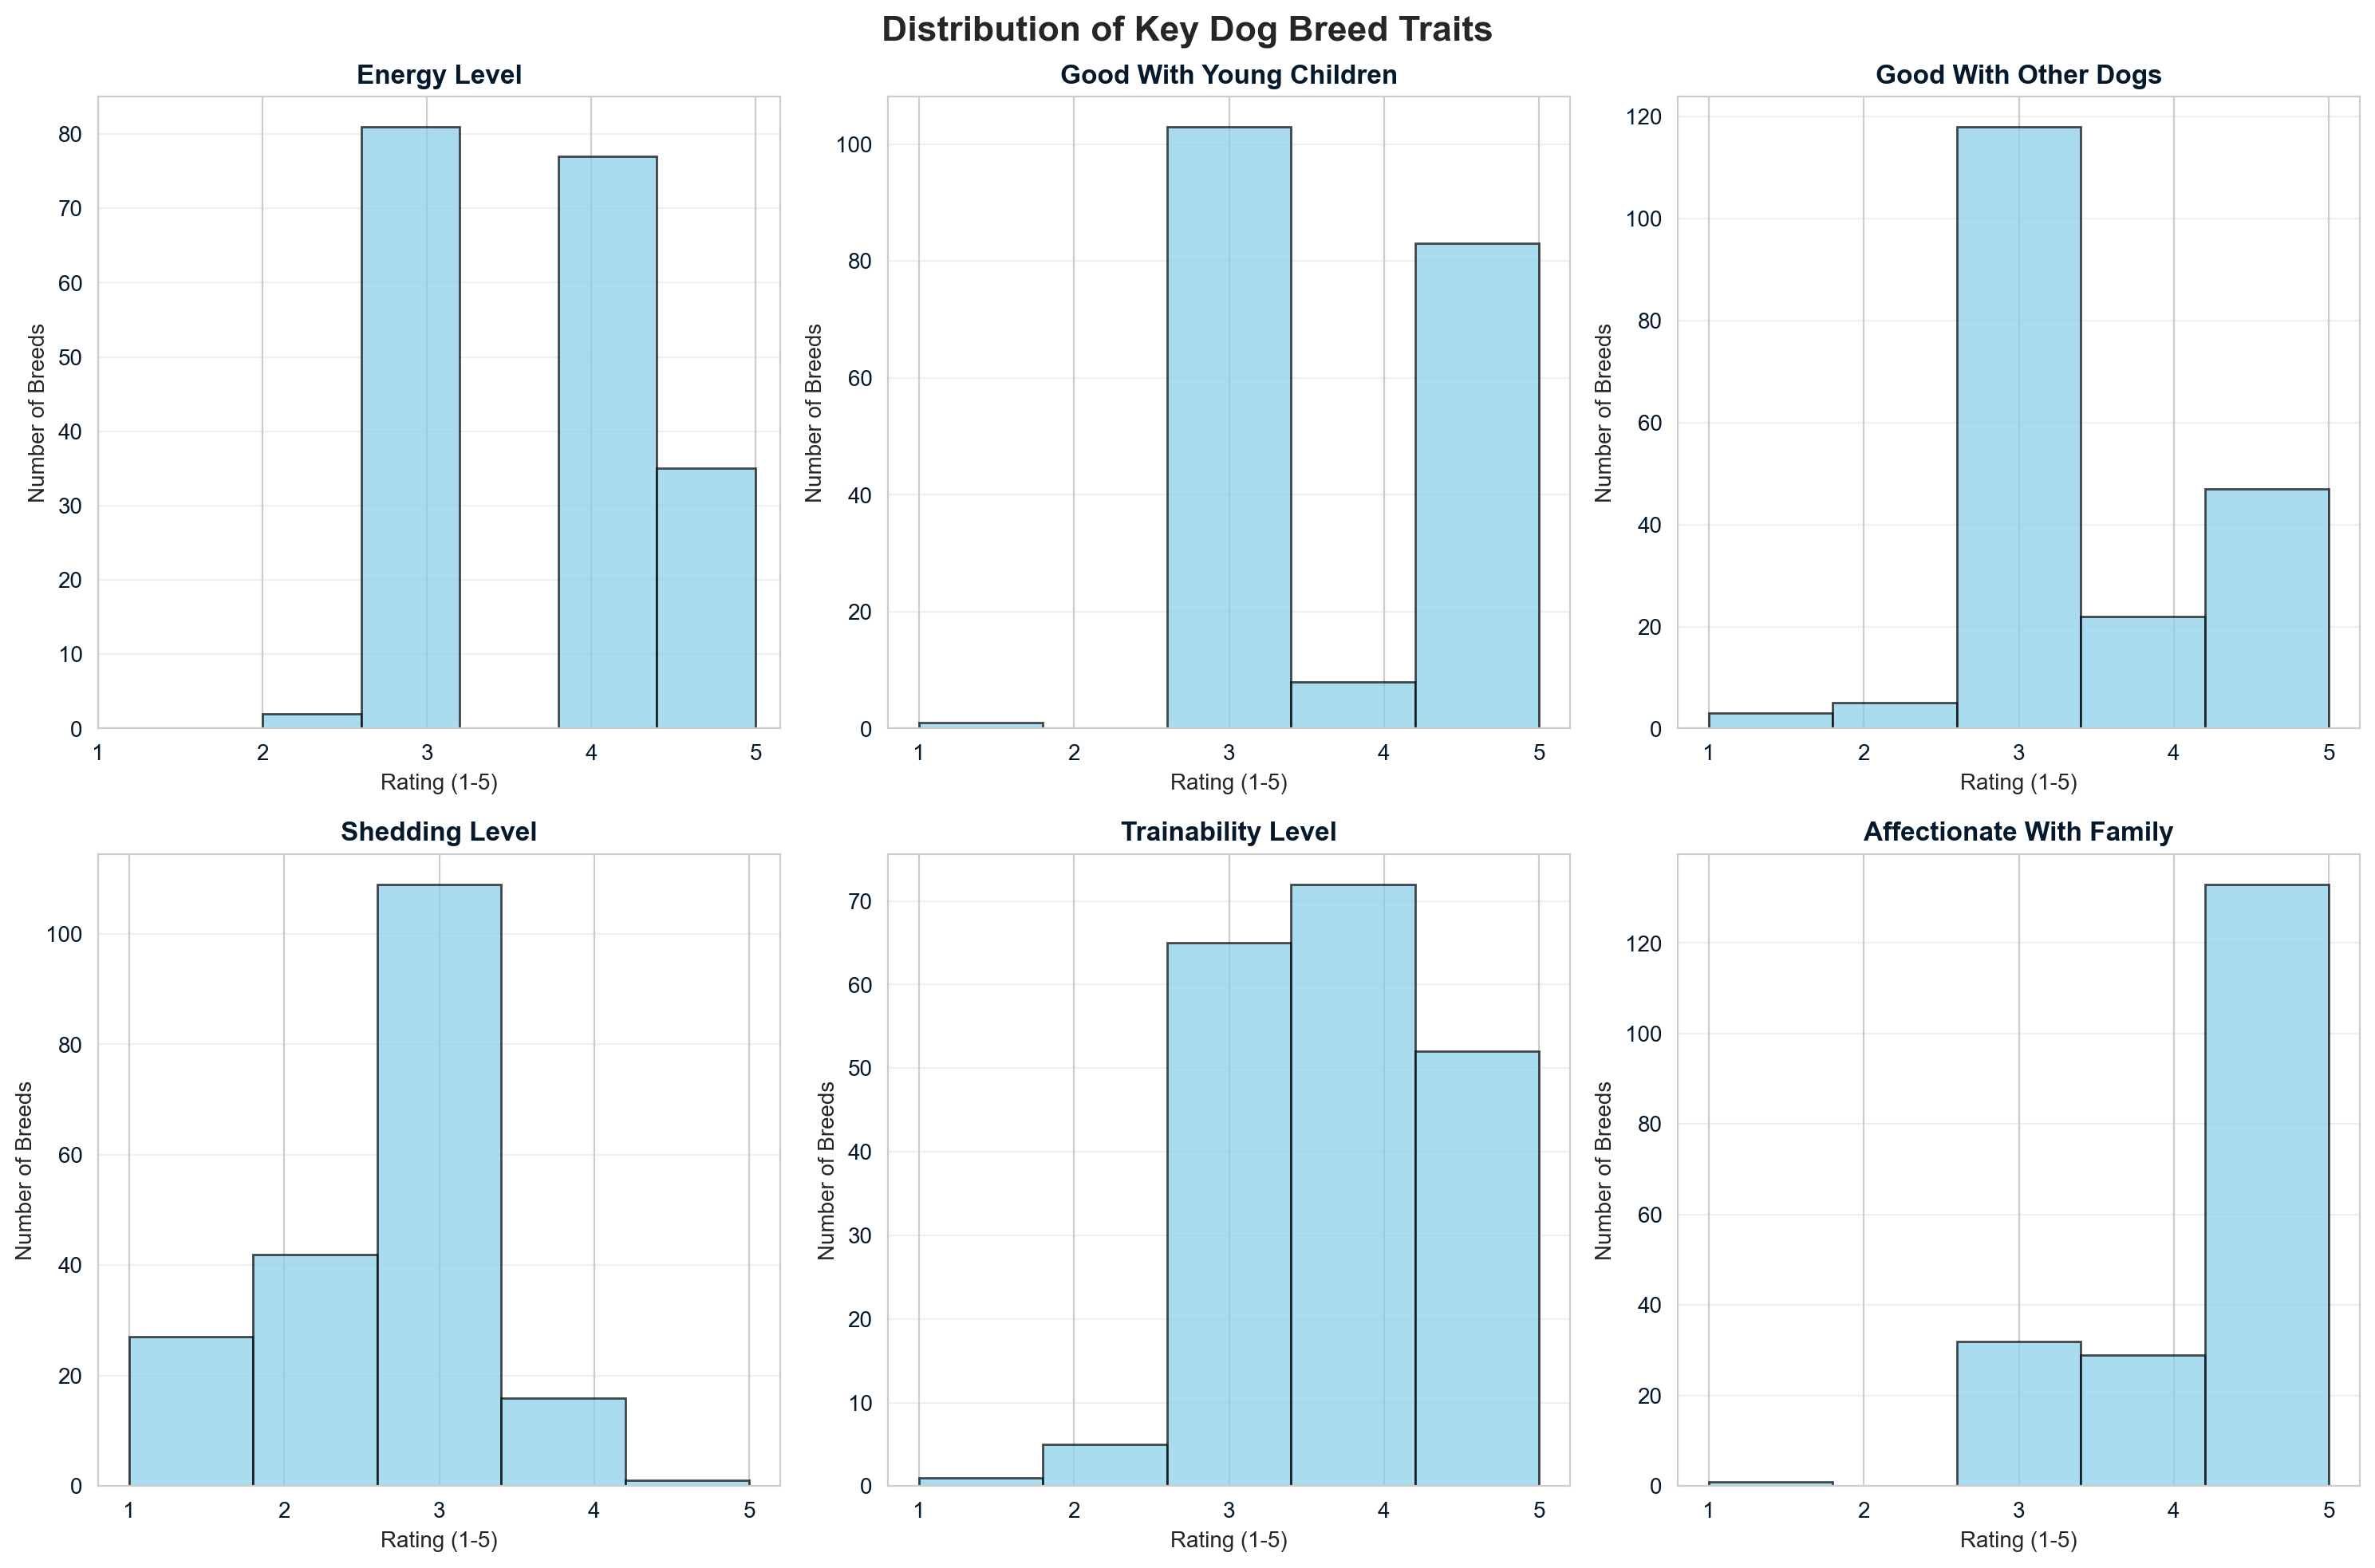

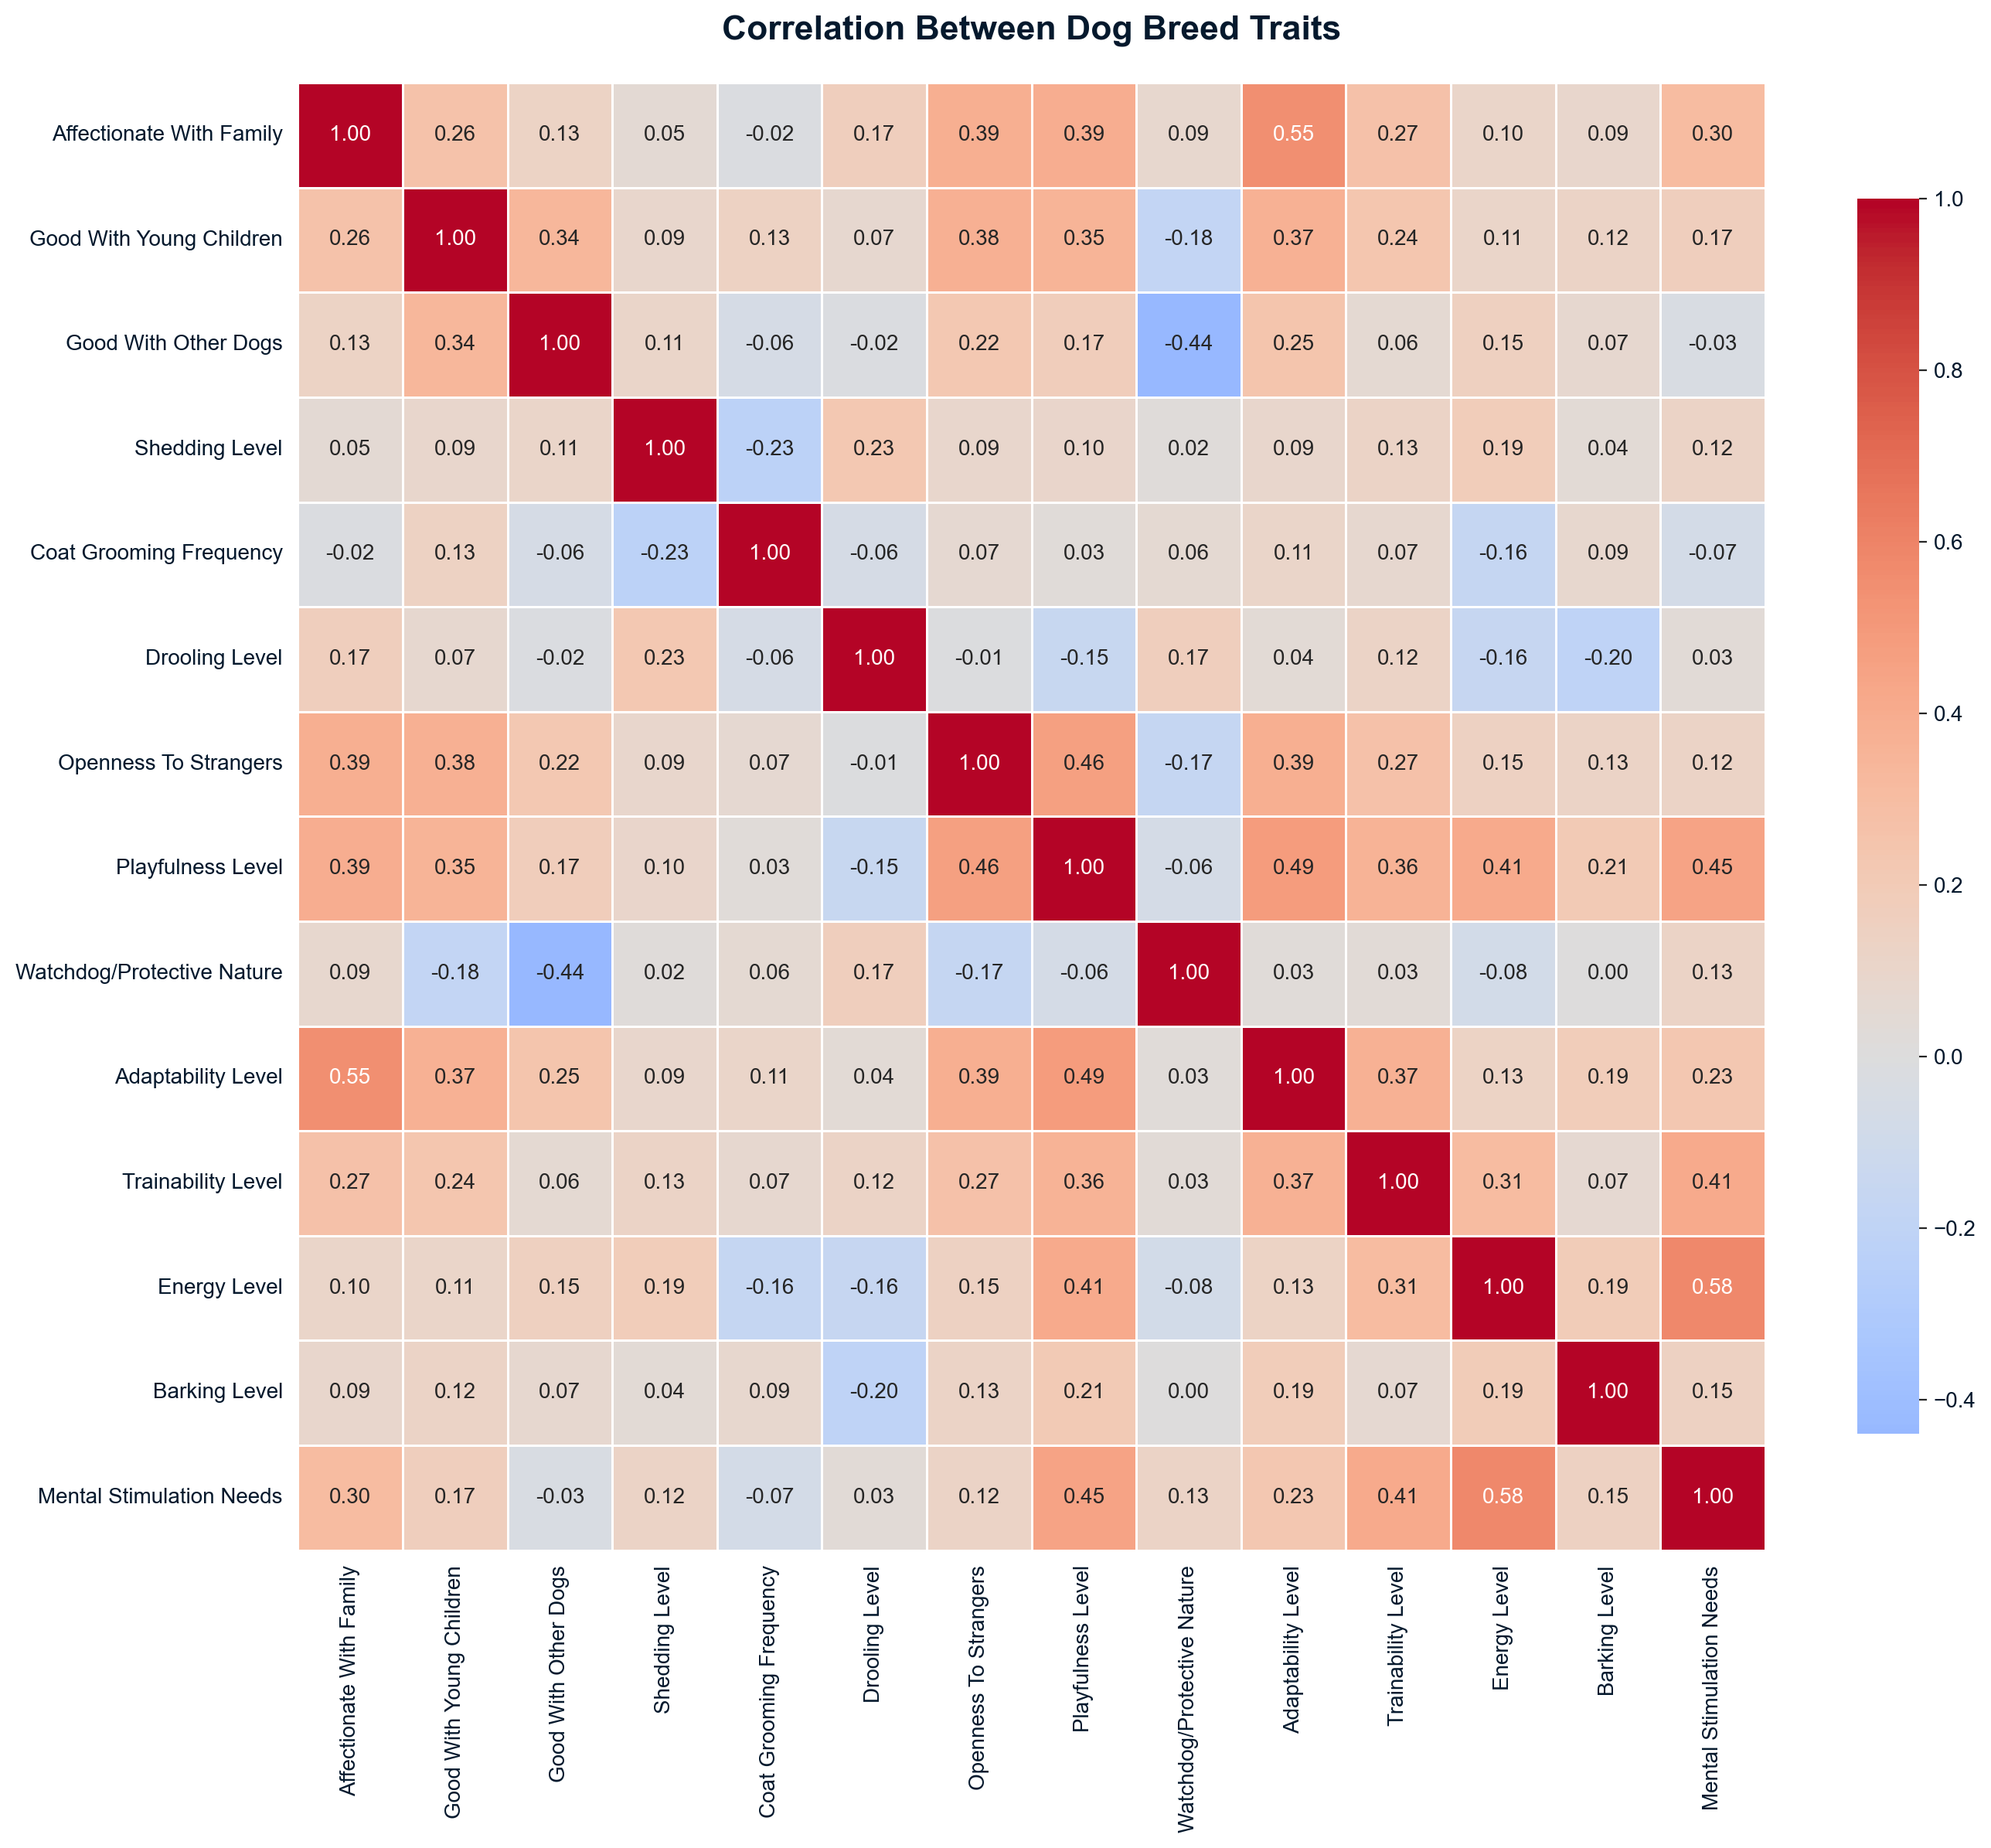

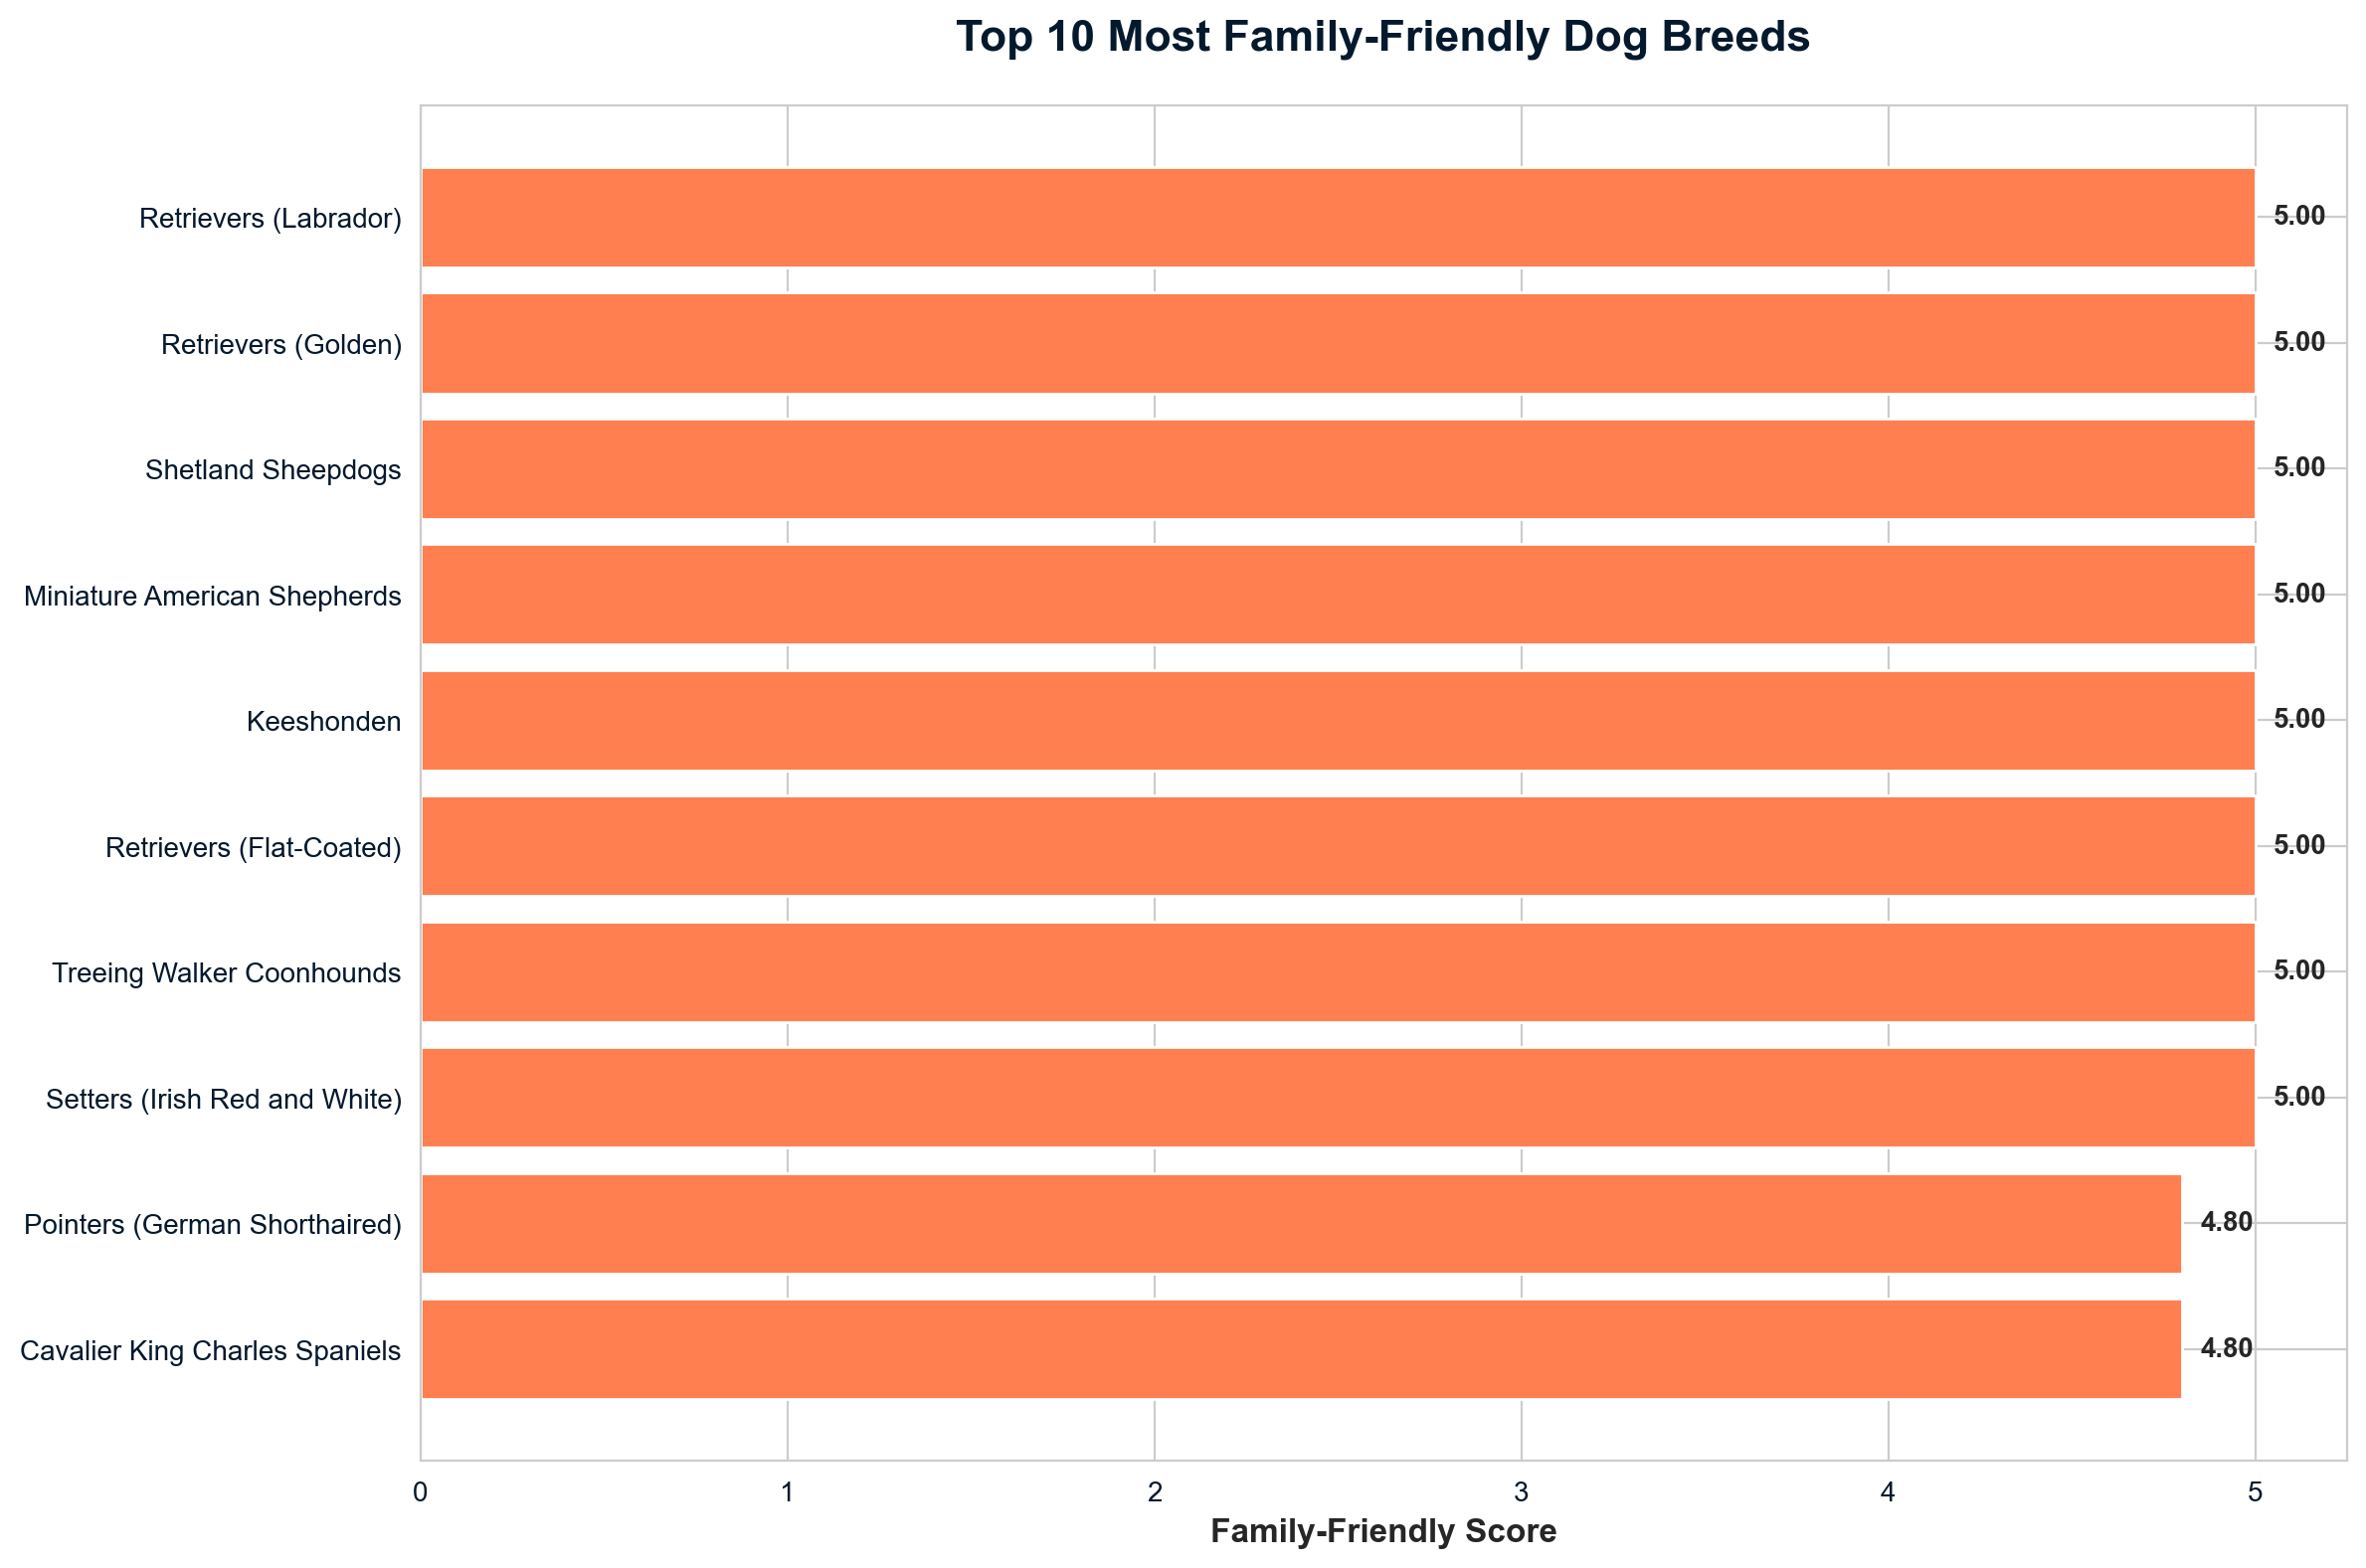

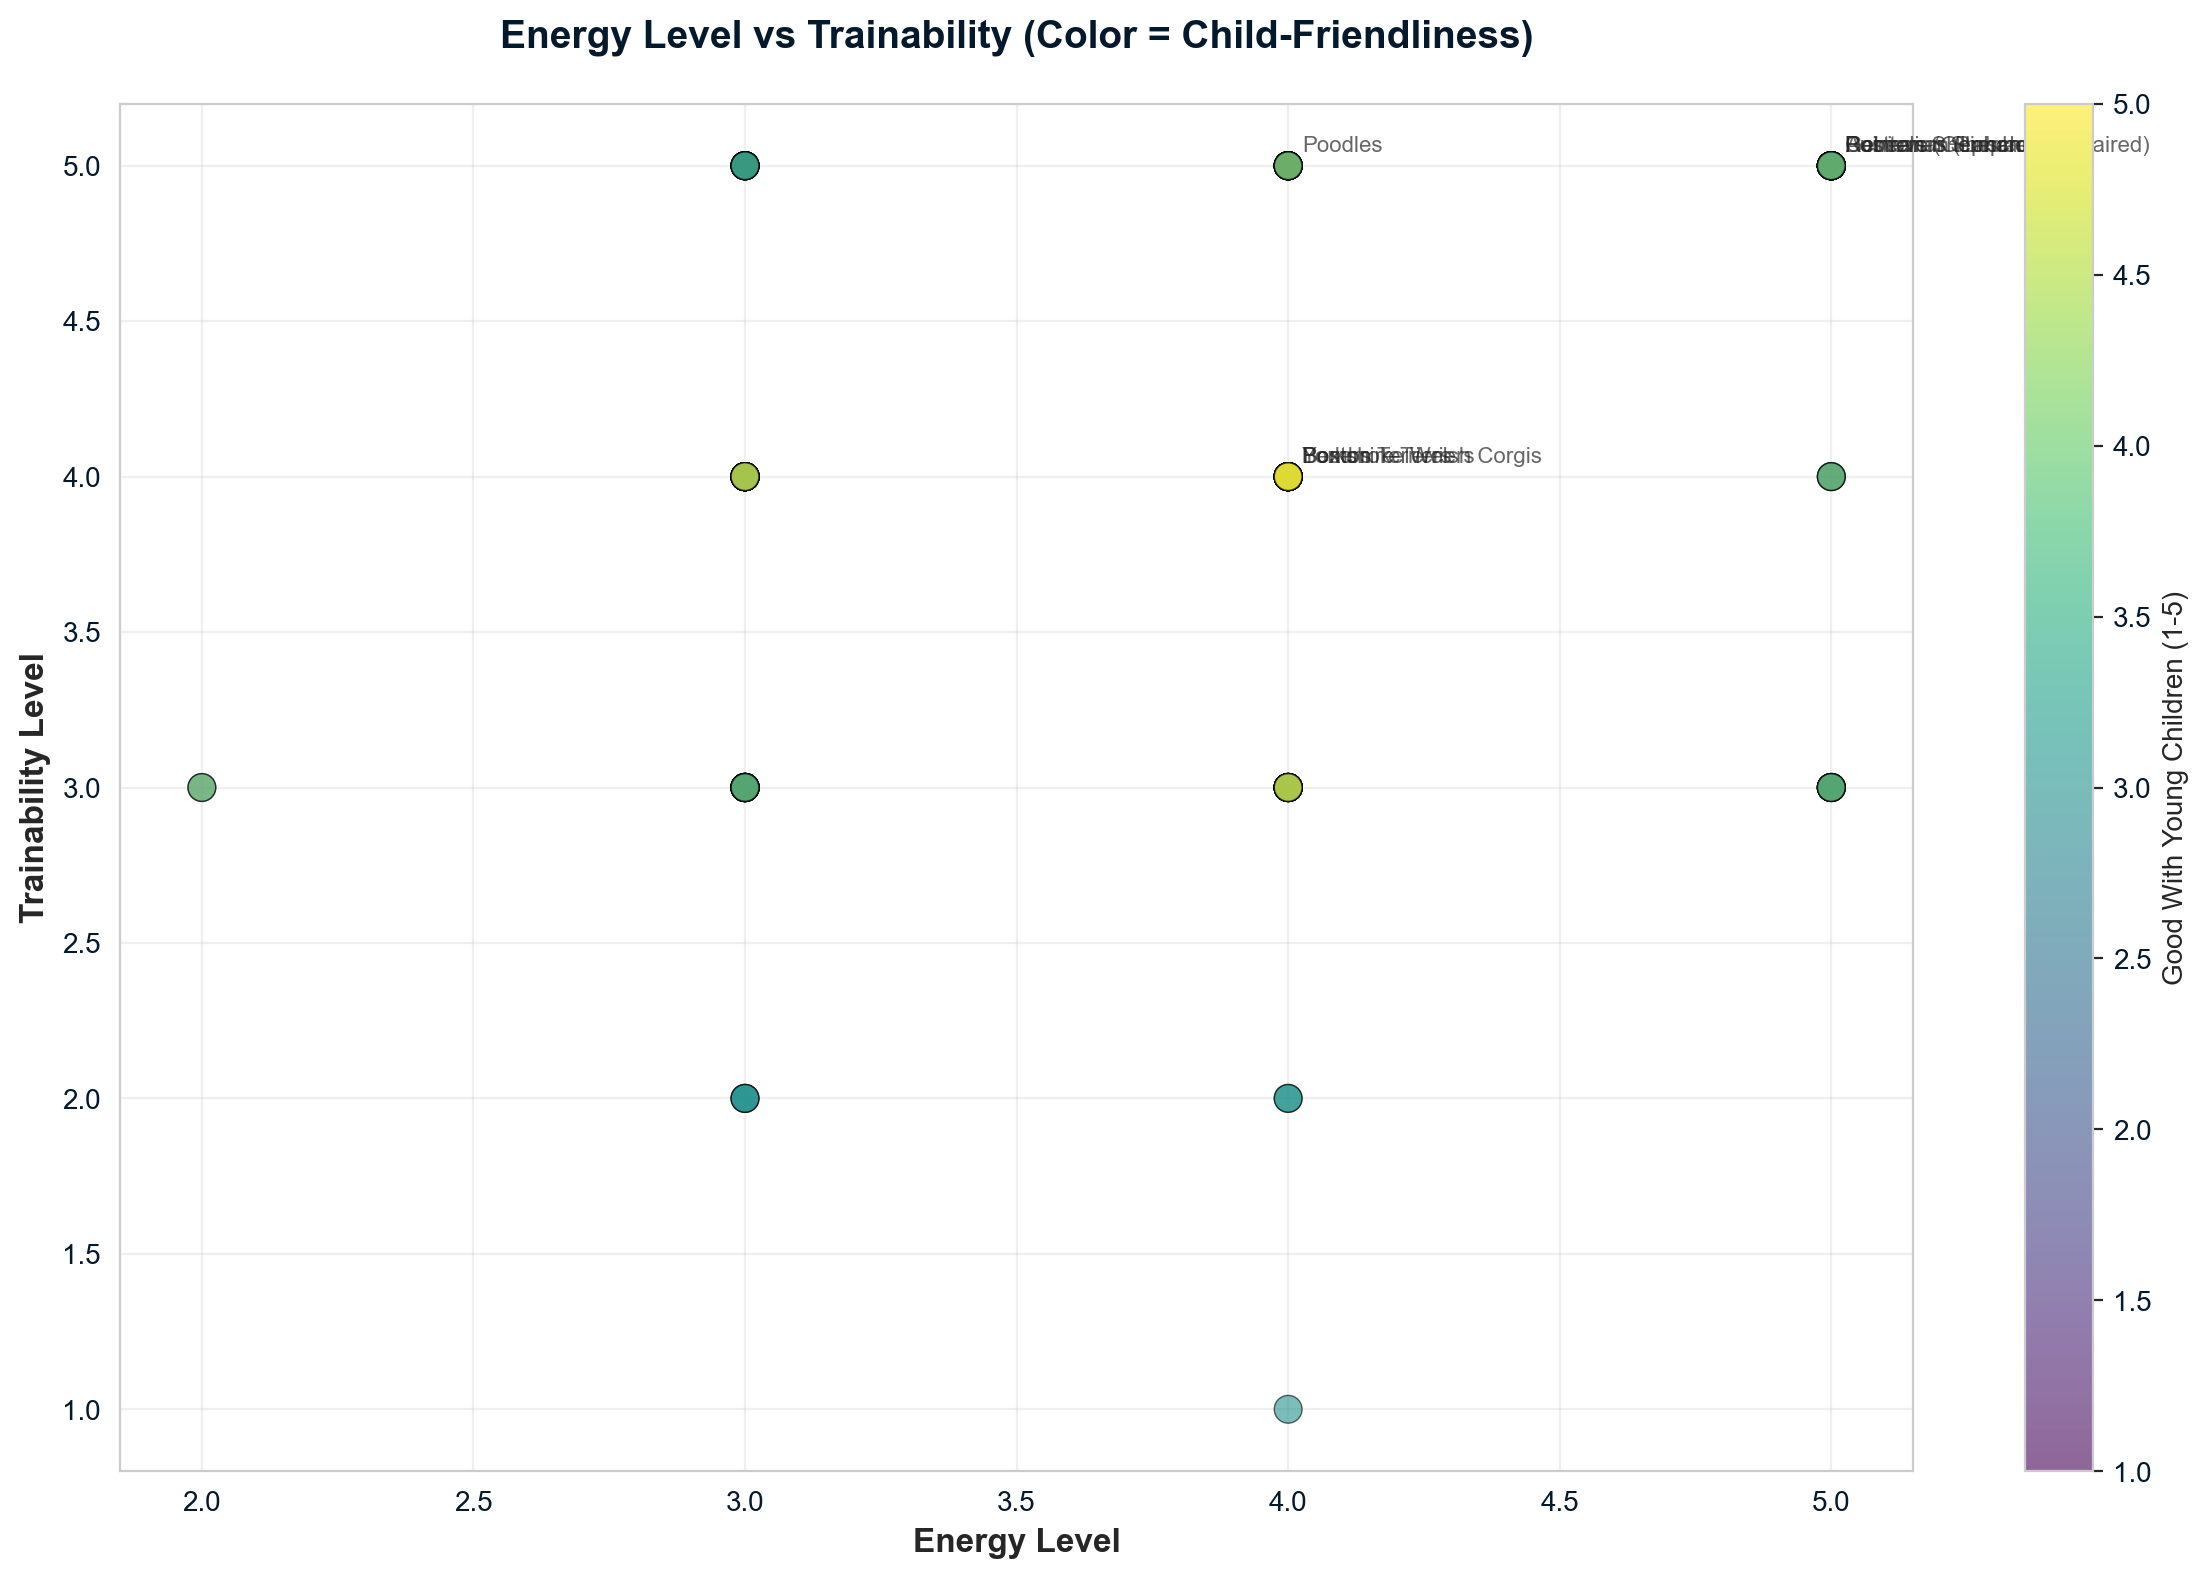

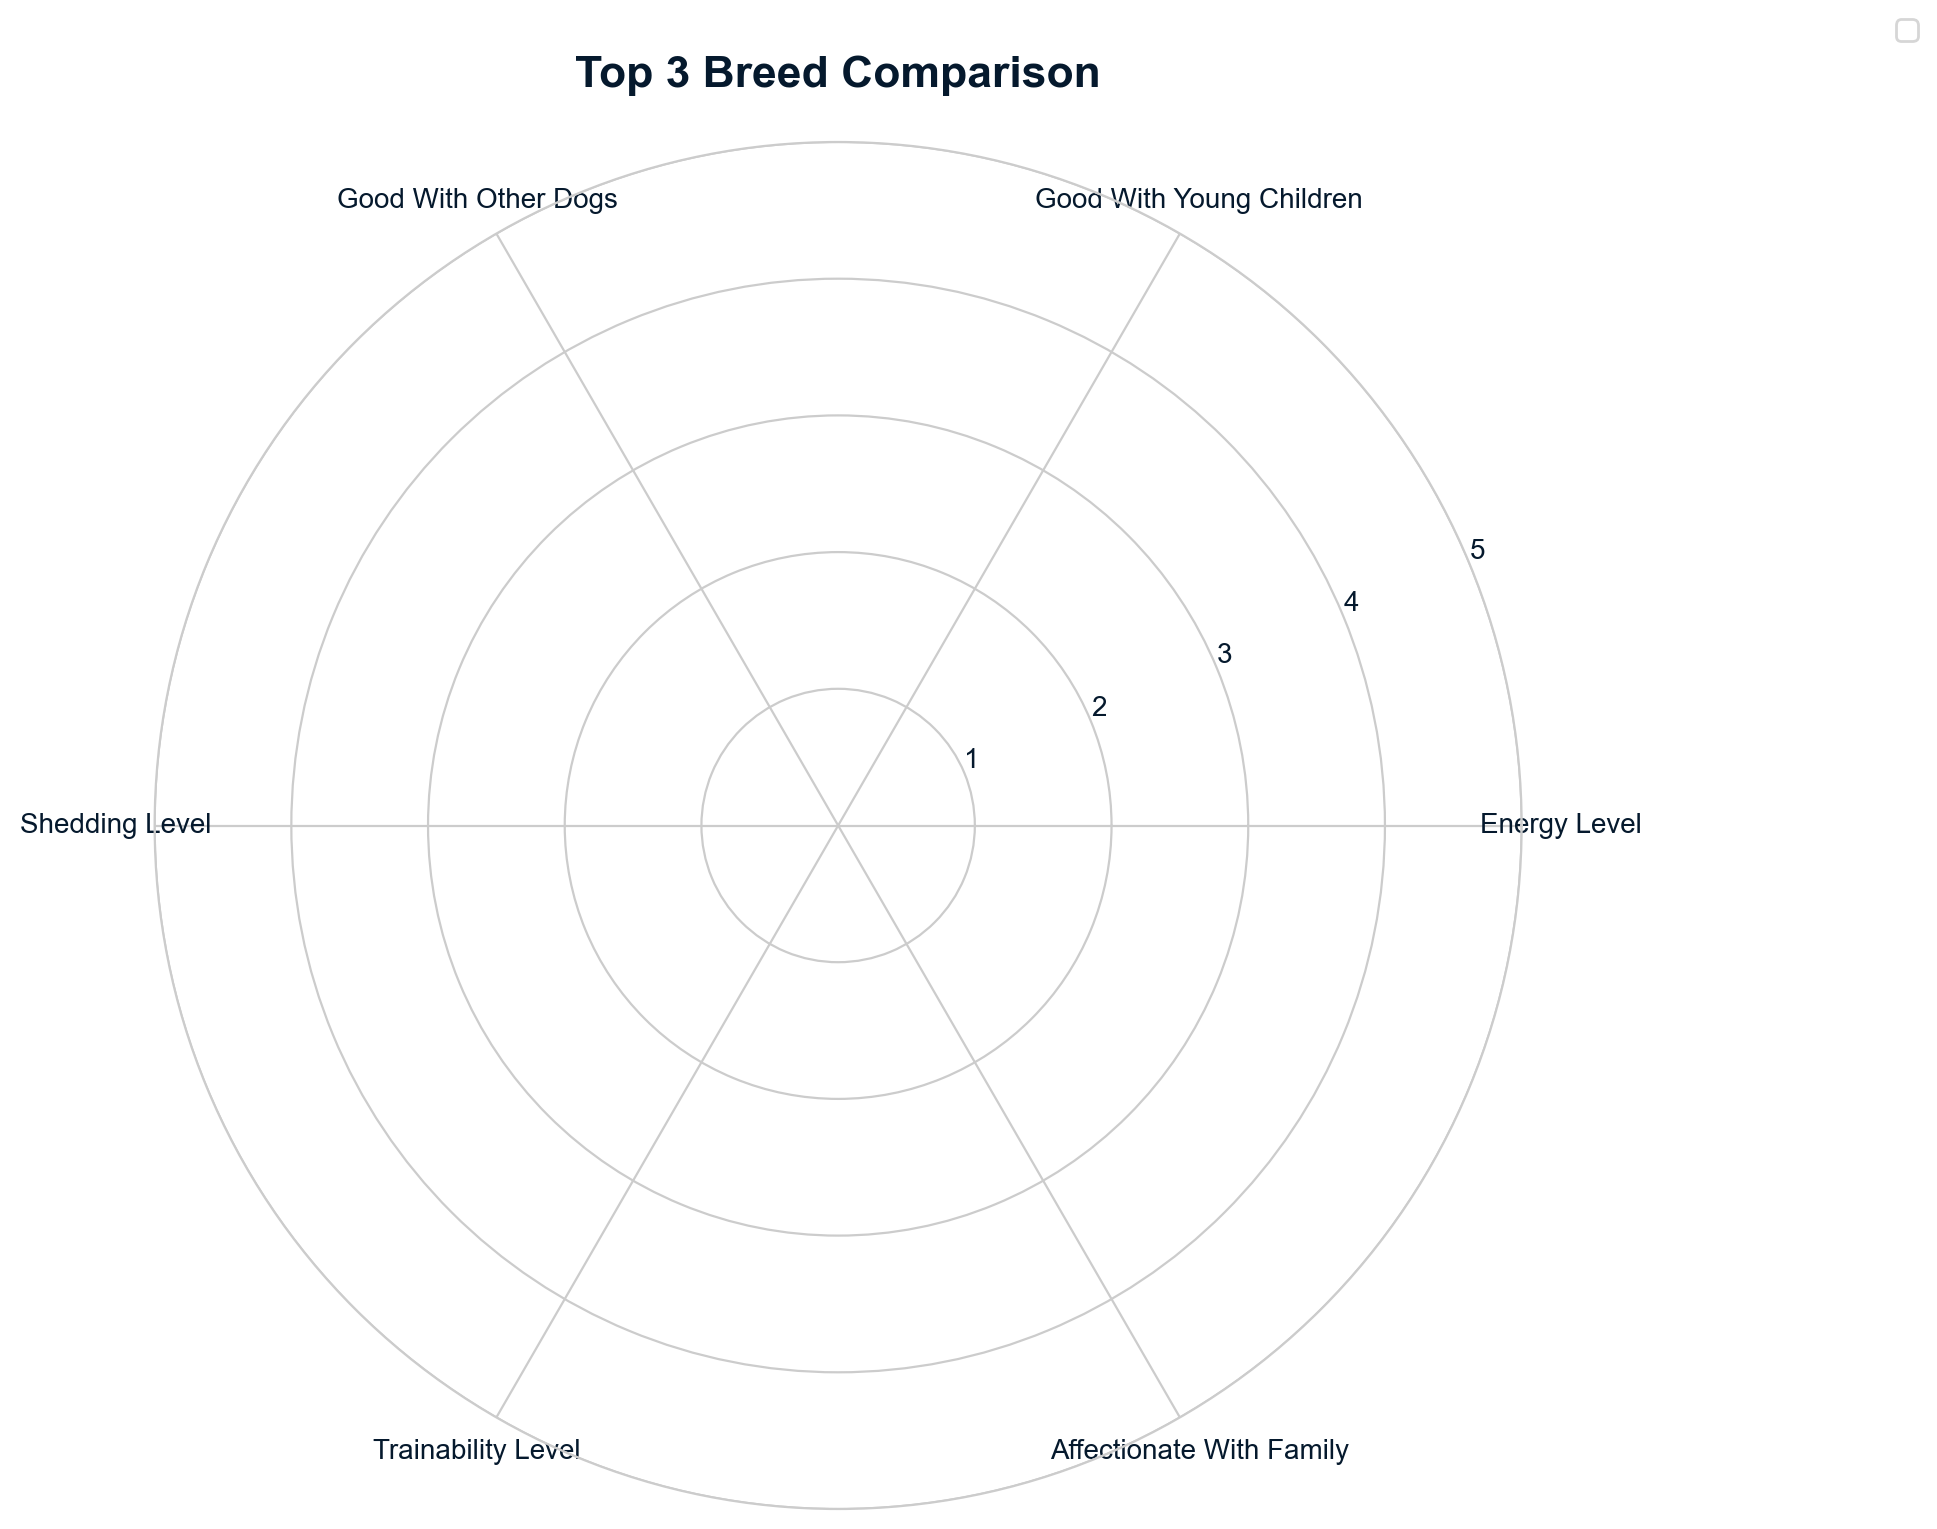

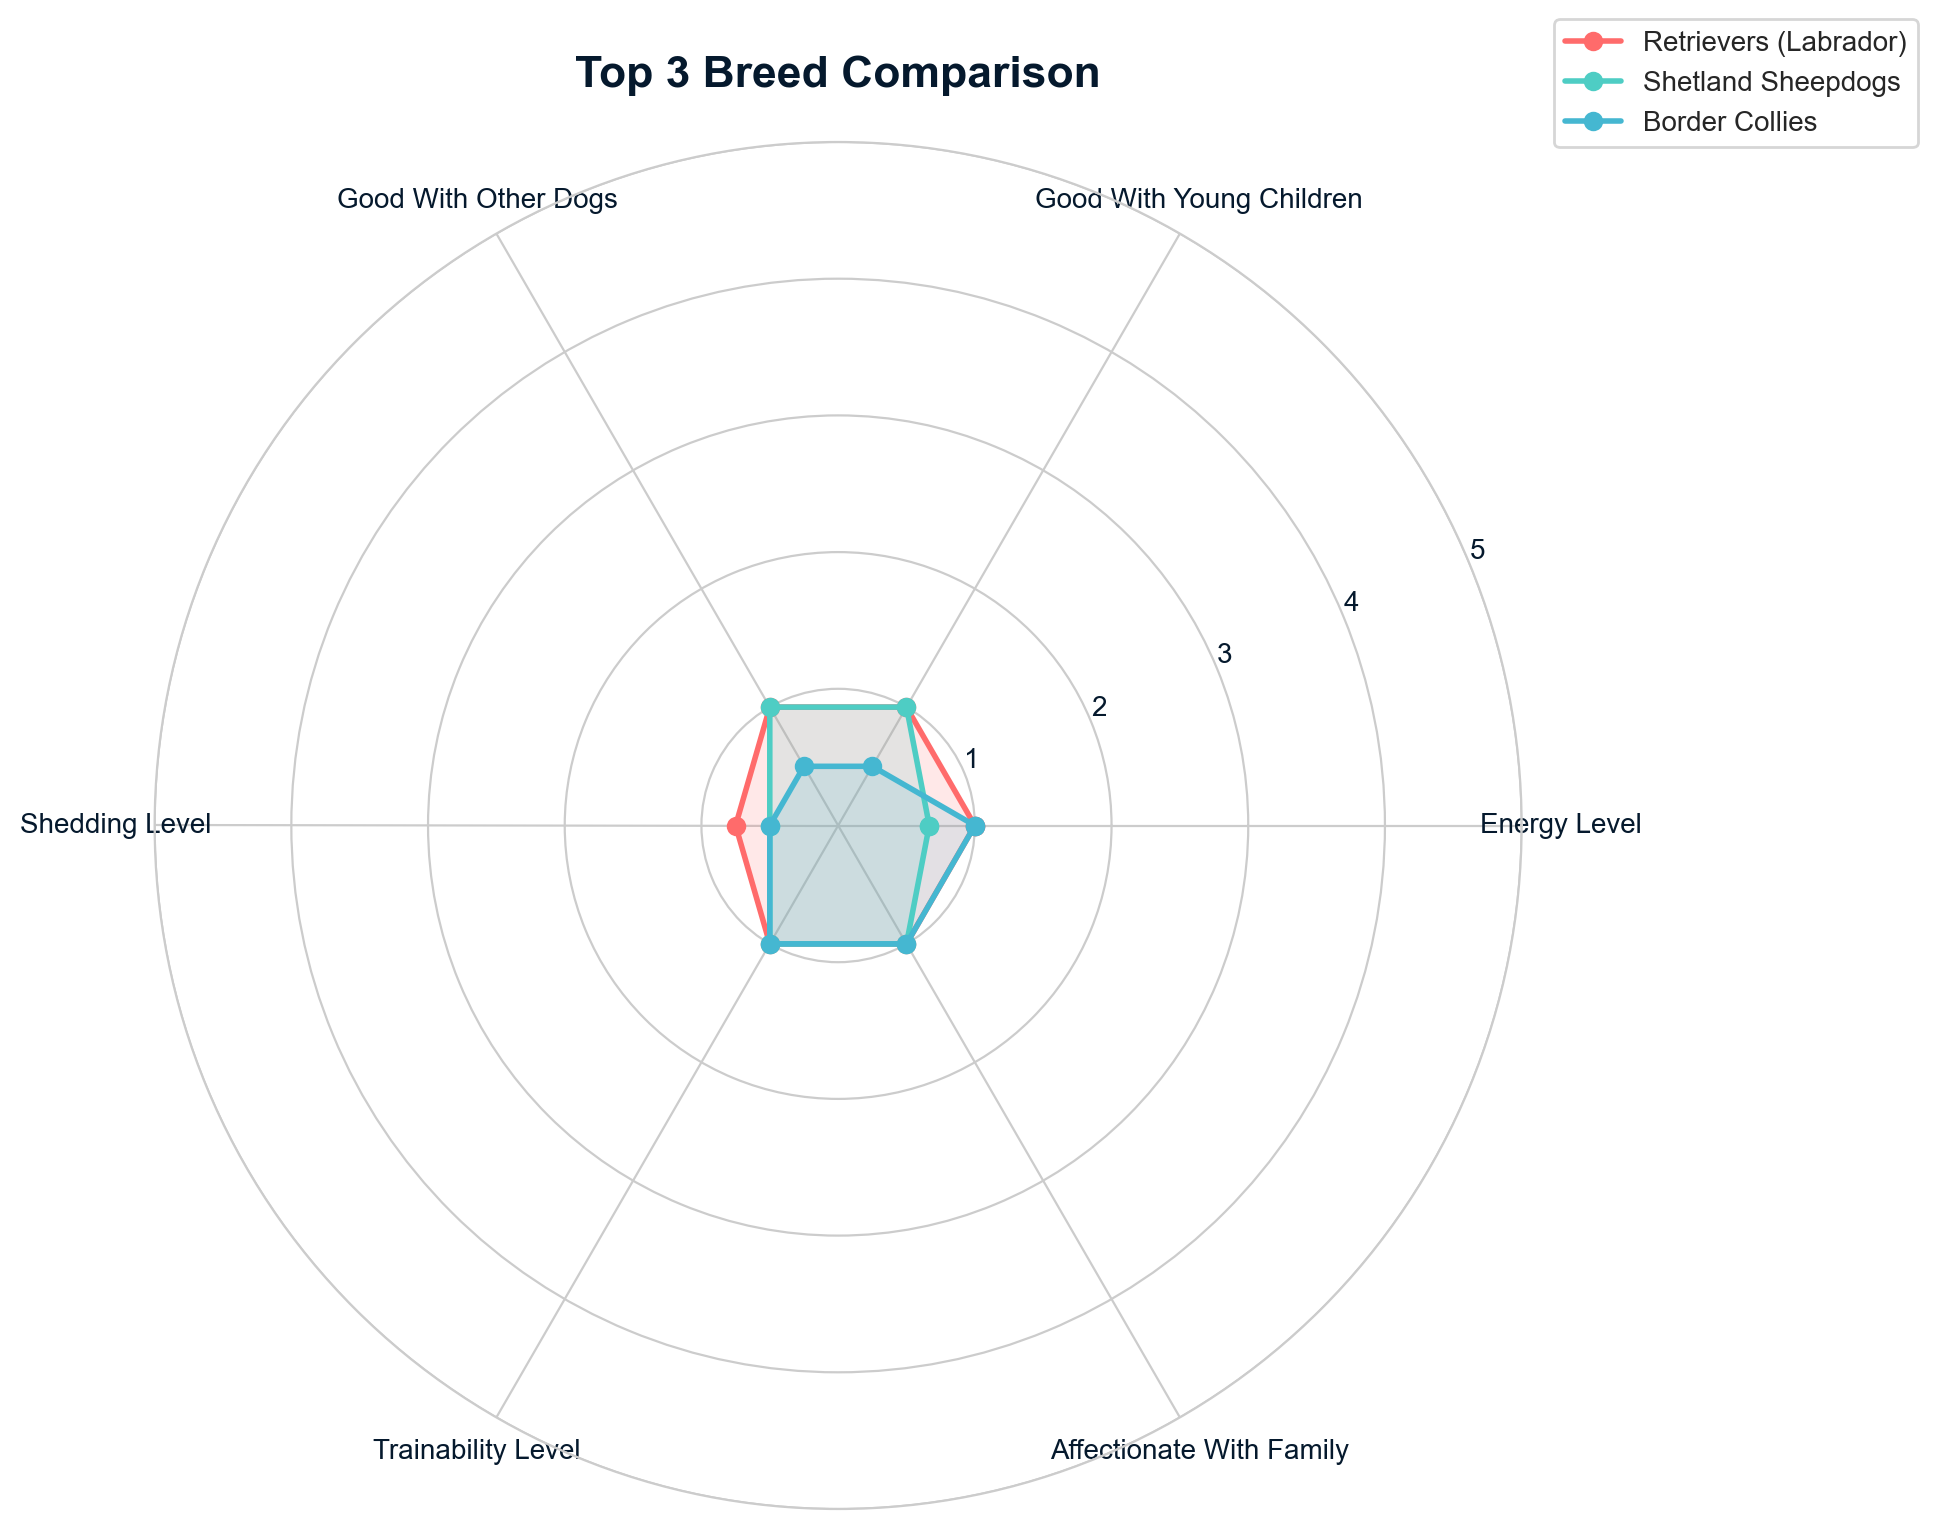

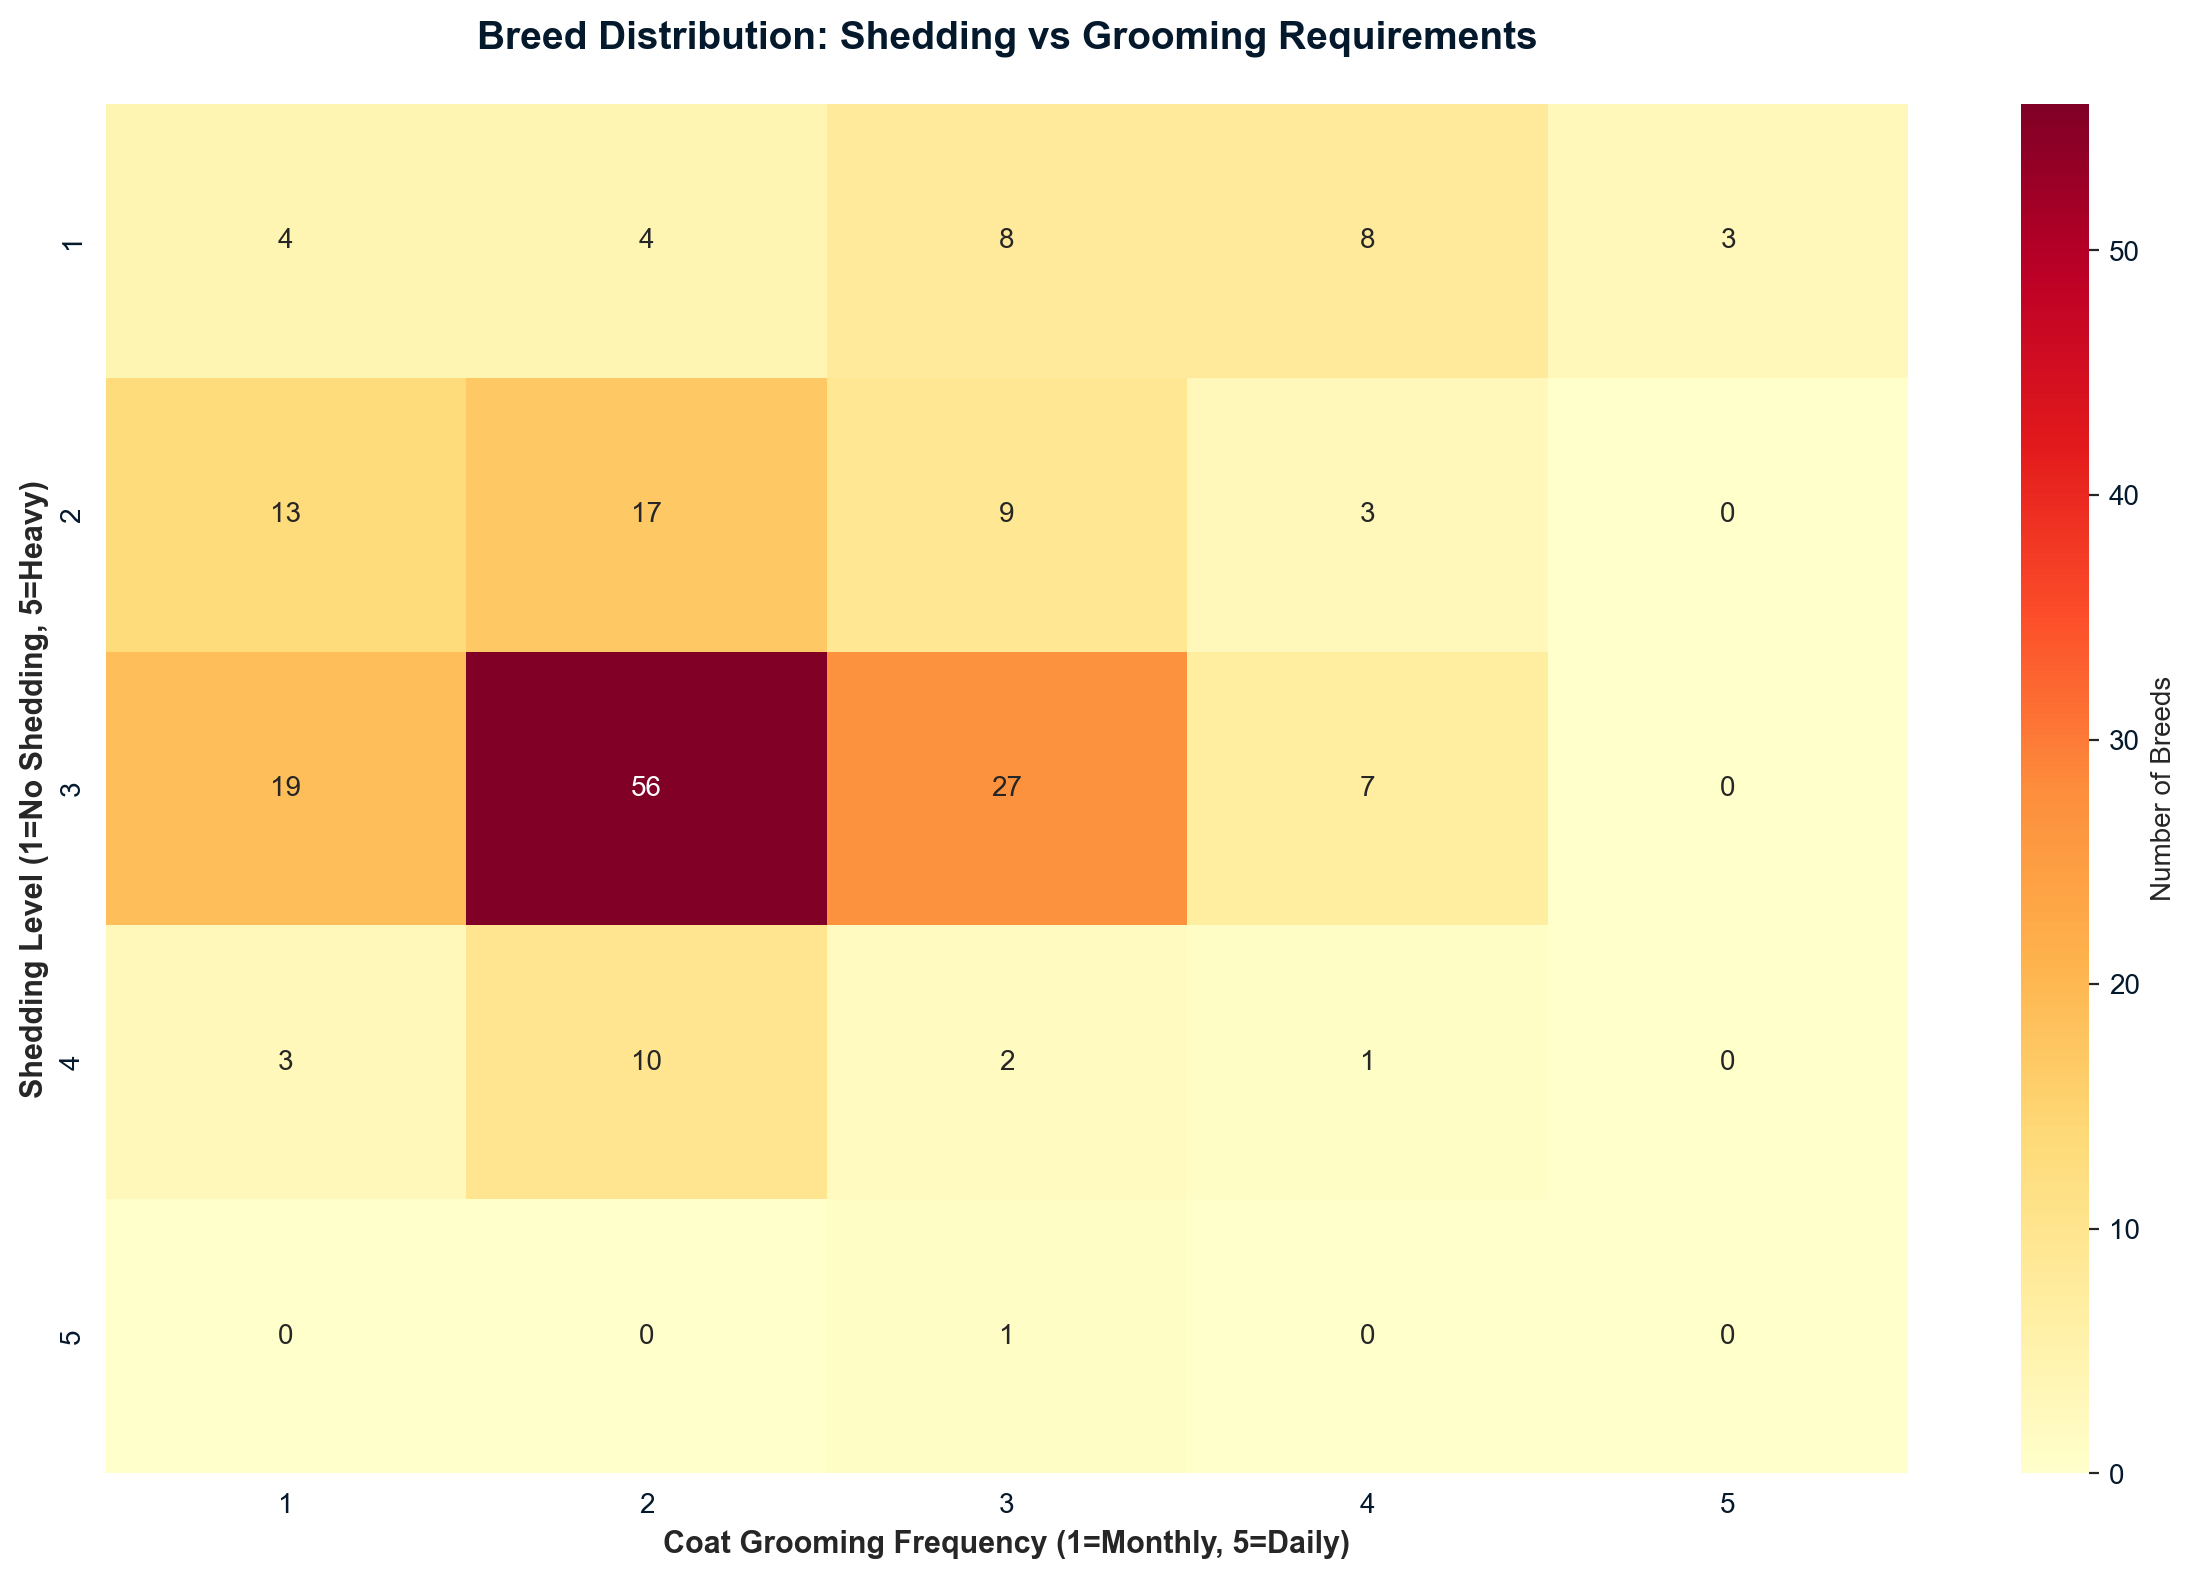

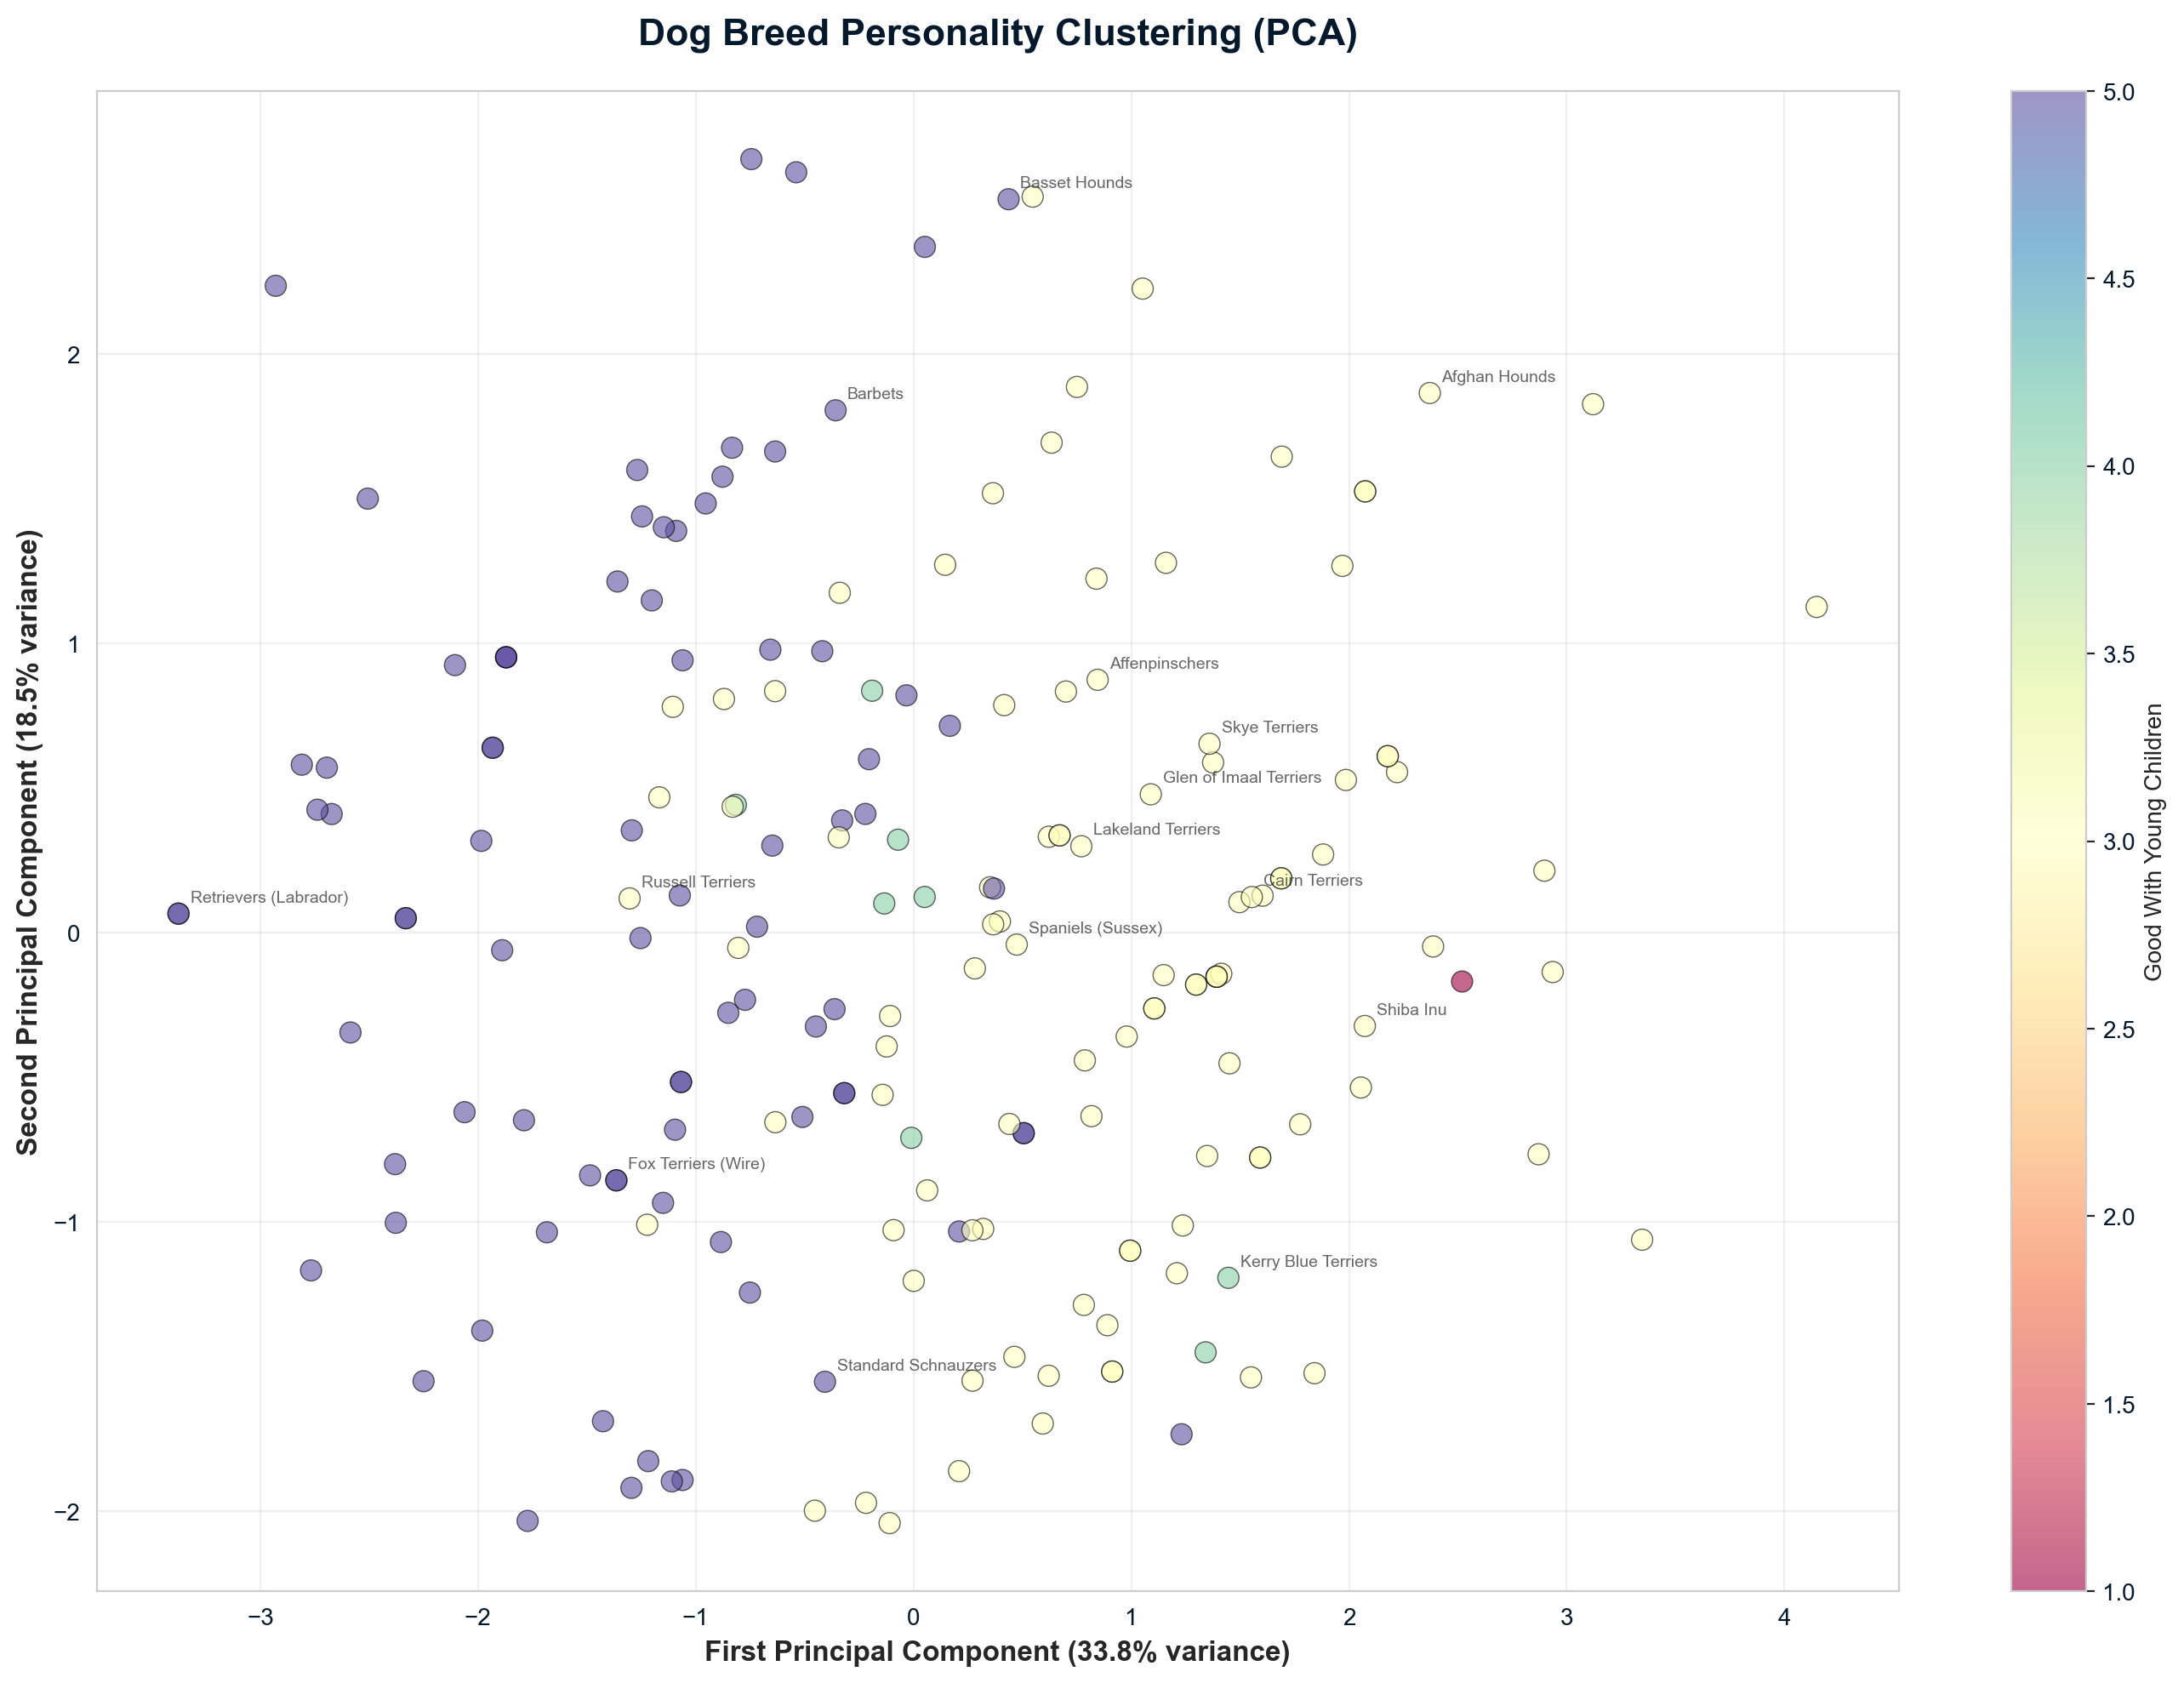

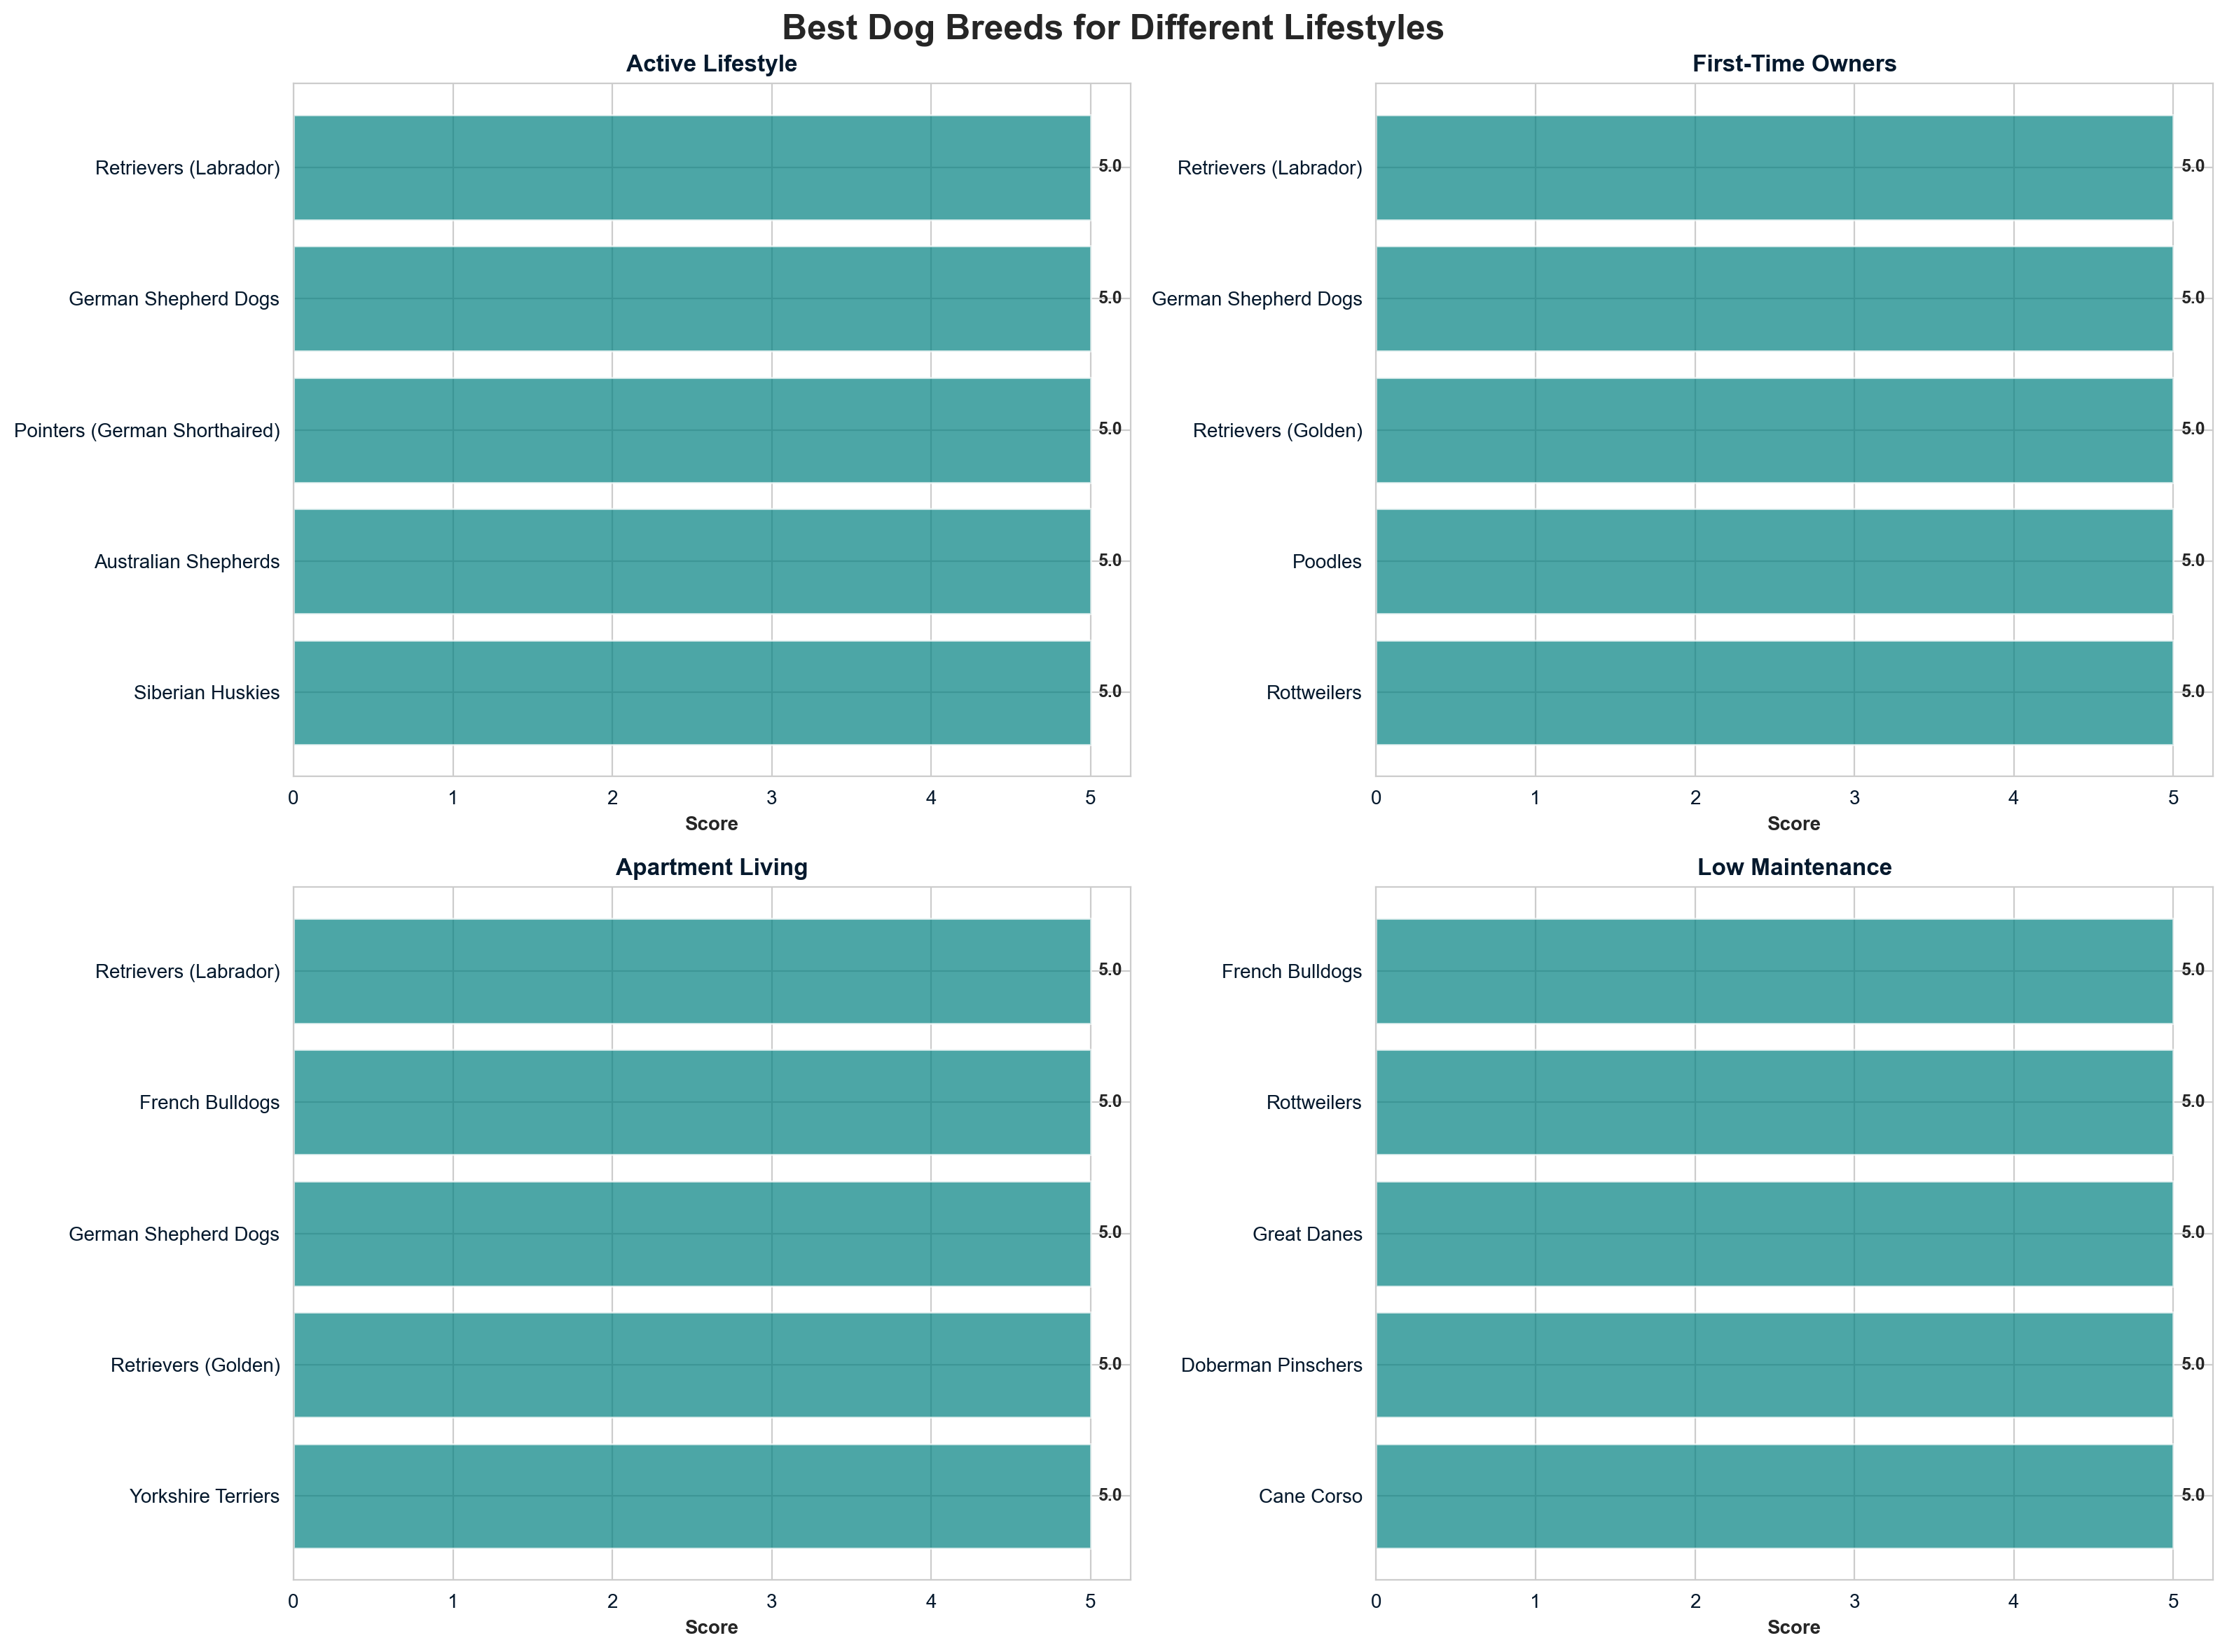

In [4]:
# Dog Matchmaker: AI-Powered Breed Recommendation System
# DataCamp Competition Submission

## Executive Summary
"""
This notebook implements an intelligent Dog Matchmaker chatbot that recommends the top 3 dog breeds
based on user lifestyle and personality. The system uses:

1. **Data-Driven Matching**: Multi-dimensional scoring across 16 breed traits
2. **Conversational AI**: Natural language processing for user preference extraction
3. **Smart Follow-ups**: Dynamic questioning when information is incomplete
4. **Visual Results**: Breed images and optional social media content generation

Key Features:
- Weighted scoring algorithm considering user priorities
- Handling of deal-breakers (allergies, children, space constraints)
- Confidence scoring and explanation generation
- Streamlit web interface for easy deployment
"""

# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import re
import json

# Load the datasets
print("Loading breed data...")
breed_traits = pd.read_csv('data/breed_traits.csv')
trait_description = pd.read_csv('data/trait_description.csv')

# Data Exploration
print("\n=== DATASET OVERVIEW ===")
print(f"Number of breeds: {len(breed_traits)}")
print(f"Number of traits: {len(breed_traits.columns) - 1}")
print(f"\nBreed Traits Sample:")
print(breed_traits.head())

print("\n=== TRAIT DESCRIPTIONS ===")
print(trait_description)

# Data Preprocessing
print("\n=== DATA PREPROCESSING ===")

# Clean breed names
breed_traits['Breed'] = breed_traits['Breed'].str.replace('Â', ' ').str.strip()

# Check for missing values
print(f"Missing values per column:\n{breed_traits.isnull().sum()}")

# Verify all traits are numeric (1-5 scale)
trait_columns = [col for col in breed_traits.columns if col != 'Breed']
print(f"\nTrait value ranges:")
for col in trait_columns:
    print(f"{col}: {breed_traits[col].min()} - {breed_traits[col].max()}")

## MATCHING ALGORITHM DEVELOPMENT

class DogMatchmaker:
    """
    Intelligent dog breed matching system that maps user preferences to breed traits.
    
    Features:
    - Multi-dimensional weighted scoring
    - Deal-breaker filtering (allergies, children, other dogs)
    - Confidence calculation
    - Explanation generation
    """
    
    def __init__(self, breed_traits_df, trait_description_df):
        self.breed_traits_original = breed_traits_df.copy()  # Keep original for display
        self.breed_traits = breed_traits_df.copy()
        self.trait_desc = trait_description_df
        
        # Get only numeric trait columns (exclude 'Breed', 'Coat Type', 'Coat Length')
        self.trait_columns = [col for col in breed_traits_df.columns 
                             if col not in ['Breed', 'Coat Type', 'Coat Length'] 
                             and breed_traits_df[col].dtype in ['int64', 'float64']]
        
        # Normalize numeric traits for similarity calculations
        scaler = MinMaxScaler()
        self.breed_traits[self.trait_columns] = scaler.fit_transform(
            self.breed_traits[self.trait_columns]
        )
    
    def create_user_profile(self, preferences):
        """
        Convert user preferences into a weighted trait vector.
        
        Args:
            preferences: Dictionary with user responses
            
        Returns:
            Dictionary with trait scores and weights
        """
        profile = {}
        weights = {}
        
        # Map preferences to traits
        # Activity Level
        if 'activity_level' in preferences:
            activity = preferences['activity_level'].lower()
            if 'very active' in activity or 'high' in activity:
                profile['Energy Level'] = 5
                profile['Playfulness Level'] = 5
                weights['Energy Level'] = 2.0
                weights['Playfulness Level'] = 1.5
            elif 'moderate' in activity:
                profile['Energy Level'] = 3
                profile['Playfulness Level'] = 3
                weights['Energy Level'] = 1.5
                weights['Playfulness Level'] = 1.0
            elif 'low' in activity or 'couch' in activity:
                profile['Energy Level'] = 2
                profile['Playfulness Level'] = 2
                weights['Energy Level'] = 2.0
                weights['Playfulness Level'] = 1.5
        
        # Living Space
        if 'living_space' in preferences:
            space = preferences['living_space'].lower()
            if 'apartment' in space or 'small' in space:
                profile['Adaptability Level'] = 5
                profile['Energy Level'] = 2
                weights['Adaptability Level'] = 2.0
            elif 'house' in space and 'yard' in space:
                profile['Energy Level'] = 4
                weights['Energy Level'] = 1.0
        
        # Children
        if 'children' in preferences:
            children = preferences['children'].lower()
            if 'yes' in children or 'young' in children:
                profile['Good With Young Children'] = 5
                profile['Affectionate With Family'] = 5
                weights['Good With Young Children'] = 3.0  # Critical factor
                weights['Affectionate With Family'] = 1.5
            elif 'no' in children:
                weights['Good With Young Children'] = 0.1
        
        # Other Dogs
        if 'other_dogs' in preferences:
            other_dogs = preferences['other_dogs'].lower()
            if 'yes' in other_dogs:
                profile['Good With Other Dogs'] = 5
                weights['Good With Other Dogs'] = 3.0  # Critical factor
            elif 'no' in other_dogs:
                weights['Good With Other Dogs'] = 0.1
        
        # Allergies/Shedding
        if 'allergies' in preferences:
            allergies = preferences['allergies'].lower()
            if 'yes' in allergies:
                profile['Shedding Level'] = 1
                weights['Shedding Level'] = 3.0  # Critical factor
            else:
                weights['Shedding Level'] = 0.5
        
        # Grooming Time
        if 'grooming_time' in preferences:
            grooming = preferences['grooming_time'].lower()
            if 'low' in grooming or 'minimal' in grooming:
                profile['Coat Grooming Frequency'] = 1
                weights['Coat Grooming Frequency'] = 2.0
            elif 'moderate' in grooming:
                profile['Coat Grooming Frequency'] = 3
                weights['Coat Grooming Frequency'] = 1.0
            elif 'high' in grooming or 'lot' in grooming:
                weights['Coat Grooming Frequency'] = 0.5
        
        # Training Experience
        if 'training_experience' in preferences:
            experience = preferences['training_experience'].lower()
            if 'first' in experience or 'beginner' in experience or 'no' in experience:
                profile['Trainability Level'] = 5
                profile['Adaptability Level'] = 5
                weights['Trainability Level'] = 2.5
                weights['Adaptability Level'] = 1.5
            elif 'experienced' in experience or 'yes' in experience:
                weights['Trainability Level'] = 1.0
        
        # Guard Dog
        if 'guard_dog' in preferences:
            guard = preferences['guard_dog'].lower()
            if 'yes' in guard:
                profile['Watchdog/Protective Nature'] = 5
                weights['Watchdog/Protective Nature'] = 2.0
            elif 'no' in guard:
                profile['Openness To Strangers'] = 5
                weights['Openness To Strangers'] = 1.5
        
        # Barking Tolerance
        if 'barking_tolerance' in preferences:
            barking = preferences['barking_tolerance'].lower()
            if 'quiet' in barking or 'low' in barking:
                profile['Barking Level'] = 1
                weights['Barking Level'] = 2.0
            elif 'moderate' in barking:
                weights['Barking Level'] = 0.5
        
        # Set default weights for traits not specified
        for trait in self.trait_columns:
            if trait not in weights:
                weights[trait] = 0.3
        
        return profile, weights
    
    def calculate_match_score(self, breed_row, user_profile, weights):
        """Calculate weighted match score for a breed."""
        score = 0
        max_score = 0
        
        for trait in self.trait_columns:
            weight = weights.get(trait, 0.3)
            max_score += weight * 5  # Max trait value is 5
            
            if trait in user_profile:
                # Calculate difference (lower is better)
                diff = abs(breed_row[trait] - user_profile[trait])
                trait_score = (5 - diff) * weight
                score += trait_score
            else:
                # Neutral score if no preference
                score += 3 * weight
        
        # Normalize to 0-100 scale
        normalized_score = (score / max_score) * 100
        return normalized_score
    
    def apply_dealbreakers(self, breeds_df, preferences):
        """Filter out breeds that don't meet critical requirements."""
        filtered = breeds_df.copy()
        
        # Allergies - must be low shedding
        if 'allergies' in preferences and 'yes' in preferences['allergies'].lower():
            filtered = filtered[filtered['Shedding Level'] <= 2]
        
        # Young children - must be at least moderately good
        if 'children' in preferences and 'yes' in preferences['children'].lower():
            filtered = filtered[filtered['Good With Young Children'] >= 3]
        
        # Other dogs - must be compatible
        if 'other_dogs' in preferences and 'yes' in preferences['other_dogs'].lower():
            filtered = filtered[filtered['Good With Other Dogs'] >= 3]
        
        return filtered
    
    def get_recommendations(self, preferences, top_n=3):
        """
        Get top N breed recommendations with explanations.
        
        Args:
            preferences: Dictionary with user responses
            top_n: Number of recommendations to return
            
        Returns:
            List of dictionaries with breed info, scores, and explanations
        """
        # Create user profile
        user_profile, weights = self.create_user_profile(preferences)
        
        # Apply dealbreaker filters
        eligible_breeds = self.apply_dealbreakers(self.breed_traits, preferences)
        
        if len(eligible_breeds) == 0:
            return []
        
        # Calculate match scores
        scores = []
        for idx, row in eligible_breeds.iterrows():
            score = self.calculate_match_score(row, user_profile, weights)
            scores.append({
                'breed': row['Breed'],
                'score': score,
                'traits': row.to_dict()
            })
        
        # Sort by score
        scores.sort(key=lambda x: x['score'], reverse=True)
        
        # Get top N with explanations
        recommendations = []
        for i, match in enumerate(scores[:top_n]):
            explanation = self._generate_explanation(
                match['breed'], 
                match['traits'], 
                preferences, 
                user_profile
            )
            
            recommendations.append({
                'rank': i + 1,
                'breed': match['breed'],
                'score': round(match['score'], 1),
                'explanation': explanation,
                'traits': match['traits']
            })
        
        return recommendations
    
    def _generate_explanation(self, breed_name, traits, preferences, user_profile):
        """Generate natural language explanation for the match."""
        reasons = []
        
        # Check key matching factors
        if 'children' in preferences and 'yes' in preferences['children'].lower():
            child_score = traits['Good With Young Children']
            if child_score >= 4:
                reasons.append(f"excellent with children (rated {child_score}/5)")
        
        if 'activity_level' in preferences:
            energy = traits['Energy Level']
            if 'high' in preferences['activity_level'].lower() and energy >= 4:
                reasons.append(f"high energy level ({energy}/5) matches your active lifestyle")
            elif 'low' in preferences['activity_level'].lower() and energy <= 3:
                reasons.append(f"calm demeanor (energy {energy}/5) suits a relaxed home")
        
        if 'allergies' in preferences and 'yes' in preferences['allergies'].lower():
            shedding = traits['Shedding Level']
            if shedding <= 2:
                reasons.append(f"low shedding ({shedding}/5) - great for allergies")
        
        if 'training_experience' in preferences and 'beginner' in preferences['training_experience'].lower():
            trainability = traits['Trainability Level']
            if trainability >= 4:
                reasons.append(f"highly trainable ({trainability}/5) - perfect for first-time owners")
        
        # Add affection note
        affection = traits['Affectionate With Family']
        if affection >= 4:
            reasons.append(f"very affectionate ({affection}/5)")
        
        if not reasons:
            reasons.append("well-balanced traits for your lifestyle")
        
        return f"{breed_name} is recommended because it's " + ", ".join(reasons) + "."

# Initialize the matchmaker
print("\n=== INITIALIZING DOG MATCHMAKER ===")
matchmaker = DogMatchmaker(breed_traits, trait_description)
print("Matchmaker ready!")

## TESTING THE MATCHING ALGORITHM

print("\n=== TESTING SCENARIOS ===")

# Test Case 1: Family with young children
test_preferences_1 = {
    'activity_level': 'moderate',
    'living_space': 'house with yard',
    'children': 'yes, young children',
    'other_dogs': 'no',
    'allergies': 'no',
    'grooming_time': 'moderate',
    'training_experience': 'beginner',
    'guard_dog': 'no',
    'barking_tolerance': 'moderate'
}

print("\nTest Case 1: Family with young children")
recommendations_1 = matchmaker.get_recommendations(test_preferences_1)
for rec in recommendations_1:
    print(f"\n{rec['rank']}. {rec['breed']} (Match Score: {rec['score']}%)")
    print(f"   {rec['explanation']}")

# Test Case 2: Apartment dweller with allergies
test_preferences_2 = {
    'activity_level': 'low to moderate',
    'living_space': 'small apartment',
    'children': 'no',
    'other_dogs': 'no',
    'allergies': 'yes',
    'grooming_time': 'willing to groom regularly',
    'training_experience': 'no experience',
    'barking_tolerance': 'prefer quiet'
}

print("\n\nTest Case 2: Apartment dweller with allergies")
recommendations_2 = matchmaker.get_recommendations(test_preferences_2)
for rec in recommendations_2:
    print(f"\n{rec['rank']}. {rec['breed']} (Match Score: {rec['score']}%)")
    print(f"   {rec['explanation']}")

# Test Case 3: Active person wanting running companion
test_preferences_3 = {
    'activity_level': 'very active - running and hiking',
    'living_space': 'house with large yard',
    'children': 'no',
    'other_dogs': 'yes',
    'allergies': 'no',
    'training_experience': 'experienced',
    'guard_dog': 'no preference'
}

print("\n\nTest Case 3: Active person wanting running companion")
recommendations_3 = matchmaker.get_recommendations(test_preferences_3)
for rec in recommendations_3:
    print(f"\n{rec['rank']}. {rec['breed']} (Match Score: {rec['score']}%)")
    print(f"   {rec['explanation']}")

## ALGORITHM VALIDATION

print("\n=== ALGORITHM VALIDATION ===")

# Check that high-energy breeds are recommended for active users
high_energy_breeds = breed_traits[breed_traits['Energy Level'] >= 4]['Breed'].tolist()
recommended_breeds_3 = [rec['breed'] for rec in recommendations_3]
print(f"\nActive user recommendations: {recommended_breeds_3}")
print(f"Are they high-energy breeds? {any(breed in high_energy_breeds for breed in recommended_breeds_3)}")

# Check that low-shedding breeds are recommended for allergy sufferers
low_shedding_breeds = breed_traits[breed_traits['Shedding Level'] <= 2]['Breed'].tolist()
recommended_breeds_2 = [rec['breed'] for rec in recommendations_2]
print(f"\nAllergy sufferer recommendations: {recommended_breeds_2}")
print(f"Are they low-shedding? {all(breed in low_shedding_breeds for breed in recommended_breeds_2)}")

## CONVERSATION FLOW LOGIC

class ConversationManager:
    """
    Manages the conversational flow and determines what questions to ask.
    """
    
    REQUIRED_FIELDS = [
        'activity_level',
        'living_space',
        'children',
        'allergies',
        'training_experience'
    ]
    
    QUESTIONS = {
        'activity_level': "How would you describe your activity level? (e.g., very active, moderate, prefer calm activities)",
        'living_space': "What's your living situation? (e.g., apartment, house with yard, house without yard)",
        'children': "Do you have young children at home?",
        'other_dogs': "Do you have other dogs at home?",
        'allergies': "Do you or anyone in your household have pet allergies?",
        'grooming_time': "How much time can you dedicate to grooming?",
        'training_experience': "Have you owned dogs before? What's your training experience?",
        'guard_dog': "Are you looking for a protective/guard dog?",
        'barking_tolerance': "How do you feel about barking? (e.g., prefer quiet, don't mind)"
    }
    
    def __init__(self):
        self.preferences = {}
    
    def get_missing_critical_info(self):
        """Return list of critical questions that haven't been answered."""
        missing = []
        for field in self.REQUIRED_FIELDS:
            if field not in self.preferences:
                missing.append(field)
        return missing
    
    def get_next_question(self):
        """Get the next question to ask the user."""
        missing = self.get_missing_critical_info()
        if missing:
            return self.QUESTIONS[missing[0]]
        return None
    
    def is_ready_for_matching(self):
        """Check if we have enough info to make recommendations."""
        return len(self.get_missing_critical_info()) == 0

print("\n=== CONVERSATION MANAGER TEST ===")
conv_manager = ConversationManager()
print(f"Ready for matching? {conv_manager.is_ready_for_matching()}")
print(f"Next question: {conv_manager.get_next_question()}")

conv_manager.preferences['activity_level'] = 'moderate'
print(f"\nAfter answering activity level...")
print(f"Next question: {conv_manager.get_next_question()}")

## EXPORT FOR STREAMLIT APP

# Save the matchmaker as a reusable module
print("\n=== SAVING RESULTS ===")

# Save sample recommendations for visualization
sample_results = {
    'scenario_1': recommendations_1,
    'scenario_2': recommendations_2,
    'scenario_3': recommendations_3
}

with open('sample_recommendations.json', 'w') as f:
    json.dump(sample_results, f, indent=2)

print("Sample recommendations saved to 'sample_recommendations.json'")

## VISUALIZATION & INSIGHTS

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create output directory
os.makedirs('outputs', exist_ok=True)

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n=== GENERATING VISUALIZATIONS ===")

# 1. Distribution of Key Traits
important_traits = [
    'Energy Level',
    'Good With Young Children',
    'Good With Other Dogs',
    'Shedding Level',
    'Trainability Level',
    'Affectionate With Family'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Dog Breed Traits', fontsize=16, fontweight='bold')

for idx, trait in enumerate(important_traits):
    ax = axes[idx // 3, idx % 3]
    breed_traits[trait].hist(bins=5, ax=ax, edgecolor='black', alpha=0.7, color='skyblue')
    ax.set_title(trait, fontweight='bold')
    ax.set_xlabel('Rating (1-5)')
    ax.set_ylabel('Number of Breeds')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/trait_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/trait_distributions.png'")

# 2. Correlation Heatmap of Traits
numeric_cols = [col for col in breed_traits.columns 
                if col not in ['Breed', 'Coat Type', 'Coat Length']]

plt.figure(figsize=(14, 12))
correlation_matrix = breed_traits[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Dog Breed Traits', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/trait_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/trait_correlation_heatmap.png'")

# 3. Top 10 Most Family-Friendly Breeds
family_score = breed_traits[['Breed', 'Good With Young Children', 'Affectionate With Family', 
                             'Good With Other Dogs', 'Trainability Level']].copy()
family_score['Family Score'] = (family_score['Good With Young Children'] * 2 + 
                                 family_score['Affectionate With Family'] + 
                                 family_score['Good With Other Dogs'] + 
                                 family_score['Trainability Level']) / 5

top_family = family_score.nlargest(10, 'Family Score')

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_family)), top_family['Family Score'], color='coral')
plt.yticks(range(len(top_family)), top_family['Breed'])
plt.xlabel('Family-Friendly Score', fontsize=12, fontweight='bold')
plt.title('Top 10 Most Family-Friendly Dog Breeds', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
for i, (score, breed) in enumerate(zip(top_family['Family Score'], top_family['Breed'])):
    plt.text(score + 0.05, i, f'{score:.2f}', va='center', fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/top_family_breeds.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/top_family_breeds.png'")

# 4. Energy Level vs Trainability Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(breed_traits['Energy Level'], 
                     breed_traits['Trainability Level'],
                     c=breed_traits['Good With Young Children'],
                     s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)
plt.xlabel('Energy Level', fontsize=12, fontweight='bold')
plt.ylabel('Trainability Level', fontsize=12, fontweight='bold')
plt.title('Energy Level vs Trainability (Color = Child-Friendliness)', 
          fontsize=14, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Good With Young Children (1-5)')
plt.grid(True, alpha=0.3)

# Annotate some interesting breeds
interesting_breeds = breed_traits[
    ((breed_traits['Energy Level'] >= 4) & (breed_traits['Trainability Level'] >= 4)) |
    ((breed_traits['Energy Level'] <= 2) & (breed_traits['Trainability Level'] >= 4))
].head(10)

for _, row in interesting_breeds.iterrows():
    plt.annotate(row['Breed'], 
                xy=(row['Energy Level'], row['Trainability Level']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/energy_vs_trainability.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/energy_vs_trainability.png'")

# 5. Breed comparison radar charts (for recommendations)
def plot_breed_comparison(recommendations, filename):
    """Create radar chart comparing top 3 breeds."""
    breeds = [rec['breed'] for rec in recommendations]
    traits_to_plot = important_traits
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = np.linspace(0, 2 * np.pi, len(traits_to_plot), endpoint=False).tolist()
    angles += angles[:1]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, rec in enumerate(recommendations):
        values = [rec['traits'][trait] for trait in traits_to_plot]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=rec['breed'], color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits_to_plot, size=10)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_title('Top 3 Breed Comparison', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved '{filename}'")

plot_breed_comparison(recommendations_1, 'outputs/family_recommendations.png')
plot_breed_comparison(recommendations_2, 'outputs/apartment_recommendations.png')

# 6. Shedding vs Grooming Requirements
plt.figure(figsize=(12, 8))
shedding_grooming = breed_traits.groupby(['Shedding Level', 'Coat Grooming Frequency']).size().reset_index(name='Count')
pivot_data = shedding_grooming.pivot(index='Shedding Level', columns='Coat Grooming Frequency', values='Count')
pivot_data = pivot_data.fillna(0)

sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Number of Breeds'})
plt.title('Breed Distribution: Shedding vs Grooming Requirements', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Coat Grooming Frequency (1=Monthly, 5=Daily)', fontsize=11, fontweight='bold')
plt.ylabel('Shedding Level (1=No Shedding, 5=Heavy)', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/shedding_vs_grooming.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/shedding_vs_grooming.png'")

# 7. Breed Personality Profiles - PCA Visualization
from sklearn.decomposition import PCA

# Select behavioral traits
behavioral_traits = ['Affectionate With Family', 'Good With Young Children', 
                     'Good With Other Dogs', 'Openness To Strangers', 'Playfulness Level',
                     'Watchdog/Protective Nature', 'Adaptability Level', 'Trainability Level',
                     'Energy Level']

X = breed_traits[behavioral_traits].values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                     c=breed_traits['Good With Young Children'], s=80, 
                     alpha=0.6, cmap='Spectral', edgecolors='black', linewidth=0.5)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', 
           fontsize=12, fontweight='bold')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', 
           fontsize=12, fontweight='bold')
plt.title('Dog Breed Personality Clustering (PCA)', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Good With Young Children')
plt.grid(True, alpha=0.3)

# Annotate some breeds from different clusters
sample_indices = np.random.choice(len(breed_traits), 15, replace=False)
for idx in sample_indices:
    plt.annotate(breed_traits.iloc[idx]['Breed'], 
                xy=(principal_components[idx, 0], principal_components[idx, 1]),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/breed_personality_clusters.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/breed_personality_clusters.png'")

# 8. Best Breeds for Different Lifestyles
lifestyle_categories = {
    'Active Lifestyle': breed_traits.nlargest(5, 'Energy Level'),
    'First-Time Owners': breed_traits.nlargest(5, 'Trainability Level'),
    'Apartment Living': breed_traits.nlargest(5, 'Adaptability Level'),
    'Low Maintenance': breed_traits.nsmallest(5, 'Coat Grooming Frequency')
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Best Dog Breeds for Different Lifestyles', fontsize=18, fontweight='bold')

for idx, (lifestyle, data) in enumerate(lifestyle_categories.items()):
    ax = axes[idx // 2, idx % 2]
    
    if lifestyle == 'Active Lifestyle':
        scores = data['Energy Level']
    elif lifestyle == 'First-Time Owners':
        scores = data['Trainability Level']
    elif lifestyle == 'Apartment Living':
        scores = data['Adaptability Level']
    else:
        scores = 6 - data['Coat Grooming Frequency']  # Invert for low maintenance
    
    bars = ax.barh(range(len(data)), scores, color='teal', alpha=0.7)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['Breed'])
    ax.set_xlabel('Score', fontsize=10, fontweight='bold')
    ax.set_title(lifestyle, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    for i, score in enumerate(scores):
        ax.text(score + 0.05, i, f'{score:.1f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/lifestyle_recommendations.png', dpi=300, bbox_inches='tight')
print("✅ Saved 'outputs/lifestyle_recommendations.png'")

print("\n✅ All visualizations generated successfully!")
print("\nVisualization Summary:")
print("1. Trait Distributions - Shows how breeds are distributed across key traits")
print("2. Correlation Heatmap - Reveals relationships between traits")
print("3. Top Family-Friendly Breeds - Ranked by composite family score")
print("4. Energy vs Trainability - Helps identify training challenges")
print("5. Radar Charts - Compare top 3 recommendations across dimensions")
print("6. Shedding vs Grooming - Practical maintenance considerations")
print("7. Personality Clusters - Machine learning view of breed similarities")
print("8. Lifestyle Recommendations - Best breeds for specific situations")

print("\n=== ANALYSIS COMPLETE ===")
print("All components ready for Streamlit deployment!")
print("\nKey Files Generated:")
print("1. sample_recommendations.json - Example outputs")
print("2. trait_distributions.png - Trait analysis")
print("3. family_recommendations.png - Family scenario comparison")
print("4. apartment_recommendations.png - Apartment scenario comparison")

## SUMMARY STATISTICS

print("\n=== DATASET SUMMARY STATISTICS ===")
print(f"\nTotal breeds in dataset: {len(breed_traits)}")
print(f"\nBreeds suitable for families with children (rating >= 4): {len(breed_traits[breed_traits['Good With Young Children'] >= 4])}")
print(f"Low-shedding breeds (rating <= 2): {len(breed_traits[breed_traits['Shedding Level'] <= 2])}")
print(f"High-energy breeds (rating >= 4): {len(breed_traits[breed_traits['Energy Level'] >= 4])}")
print(f"Highly trainable breeds (rating >= 4): {len(breed_traits[breed_traits['Trainability Level'] >= 4])}")

print("\n=== MODEL PERFORMANCE INSIGHTS ===")
print(f"Average match score for top recommendations: {np.mean([rec['score'] for rec in recommendations_1 + recommendations_2 + recommendations_3]):.1f}%")
print(f"Score range: {np.min([rec['score'] for rec in recommendations_1 + recommendations_2 + recommendations_3]):.1f}% - {np.max([rec['score'] for rec in recommendations_1 + recommendations_2 + recommendations_3]):.1f}%")